# Baseline Solution - Monte Carlo Dropout

## This notebook documents the baseline solution for ADC 2022. 

## Overview
Our challenge is to provide 1. an error estimates (for Light Track) and/or 2. a conditional probability distribution (for Regular Track) for each target (6 in total) given an observation from the Ariel Space Telescope. The light track encourages a natural progression to the regular track. Participants are welcomed to join either or both tracks as they see fit. 

Depending on the information content of the observation and the associated observation noise (which is a function of the instrument and the planetary system), the resultant error bounds on each target and their joint conditional distribution will be different.

There are many directions you can take to tackle the problem on hand. We would like to get you started with our baseline solution. 

Spectroscopic data alone are usually informative enough to provide a reasonable estiamte on the targets. After all, the trough and peaks in the spectra encoded information about the relative abundance of each gaseous species (see [Yip et al.](https://iopscience.iop.org/article/10.3847/1538-3881/ac1744>) ). The supplementary information also helps to better constrain some of the phyiscal quantities (see our discussion [here](https://www.ariel-datachallenge.space/ML/documentation/about) if you want to learn about the underlying physics :) , but I shall leave that to you. 

The baseline solution trains a CNN to output a deterministic estimate for each atmospheric target. At inference time, the network is made to produce probabilistic output by activating the dropout layers in the network (Monte Carlo Dropout, [Gal et al. 2016](https://arxiv.org/abs/1506.02142)). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import h5py
import os
import matplotlib.pyplot as plt
from keras.layers import Dense, Reshape, Input, Concatenate, BatchNormalization, Dropout, Conv1D,Flatten,MaxPooling1D
from keras.models import Model
from tqdm import tqdm
from helper import *
from preprocessing import *
from submit_format import *
from MCDropout import MC_Convtrainer
from tqdm import tqdm

# Fix seed


In [2]:
np.random.seed(42)
keras.utils.set_random_seed(42)

## Constants

In [3]:
RJUP = 69911000
MJUP = 1.898e27
RSOL = 696340000

## Read training data

In [4]:
training_path = 'TrainingData/'

In [5]:
test_path = 'TestData/'

In [6]:
training_GT_path = os.path.join(training_path, 'Ground Truth Package')

In [7]:
spectral_training_data = h5py.File(os.path.join(training_path,'SpectralData.hdf5'),"r")
aux_training_data = pd.read_csv(os.path.join(training_path,'AuxillaryTable.csv'))
soft_label_data = pd.read_csv(os.path.join(training_GT_path, 'FM_Parameter_Table.csv'))

In [8]:
aux_training_data

,planet_ID,star_distance,star_mass_kg,star_radius_m,star_temperature,planet_mass_kg,planet_orbital_period,planet_distance,planet_radius_m,planet_surface_gravity
0,0,100.0510,1.531871e+30,612216000.0,5053.0,4.994682e+25,3.646200,0.042501,1.751739e+07,10.389141
1,1,28.2938,1.536643e+30,542646000.0,5071.0,3.040857e+25,16.201656,0.114991,1.309706e+07,11.315104
2,2,258.8930,1.888989e+30,688743000.0,5416.0,9.850620e+25,88.406553,0.381830,2.628654e+07,9.099284
3,3,1010.2800,2.087830e+30,751356000.0,5900.0,1.954940e+28,3.575320,0.046513,7.040038e+07,251.764117
4,4,1070.1700,2.028178e+30,953109000.0,5866.0,5.997680e+25,31.588900,0.196877,1.964499e+07,9.919505
...,...,...,...,...,...,...,...,...,...,...
91387,91387,491.6220,2.050597e+30,730485000.0,5925.1,3.779878e+27,4.847033,0.056630,1.135206e+08,18.721422
91388,91388,316.2280,2.444501e+30,980937000.0,6287.0,5.845108e+27,8.493018,0.087271,1.322829e+08,21.320410
91389,91389,1050.6400,1.869105e+30,667872000.0,5888.0,2.922920e+25,5.687945,0.061092,1.286362e+07,11.274586
91390,91390,90.8693,1.470204e+30,509042994.3,4820.4,4.095183e+25,6.096347,0.059057,1.550217e+07,10.876742


## Extract Spectral data
Spectral data lives in a h5py format, which is useful for navigating different cases, but their format makes it difficult to bulk manage them. The helper function helps to transform the h5py file into a matrix of size N x 52 x 4
where N is the number of training examples, 52 is the number of wavelength channels and 4 is the observation data

In [9]:
#spec_matrix = to_observed_matrix(spectral_training_data,aux_training_data)
#print("spectral matrix shape:", spec_matrix.shape)

In [10]:
#np.save('spec_matrix.npy',spec_matrix)

In [11]:
spec_matrix = np.load('spec_matrix.npy')

In [12]:
(spec_matrix[1,1,0]-spec_matrix[1,0,0])/spec_matrix[1,0,0]**2

-0.00872449038230475

In [13]:
(spec_matrix[1,:,3])/(spec_matrix[1,:,0])

array([0.06562666, 0.06562666, 0.06562666, 0.06562666, 0.06562666,
       0.06562666, 0.06562666, 0.06562666, 0.06562666, 0.06562666,
       0.01990198, 0.01990198, 0.01990198, 0.01990198, 0.01990198,
       0.01990198, 0.01990198, 0.01990198, 0.01990198, 0.01990198,
       0.01990198, 0.01990198, 0.01990198, 0.01990198, 0.01990198,
       0.01990198, 0.01990198, 0.01990198, 0.01990198, 0.01990198,
       0.01990198, 0.01990198, 0.01990198, 0.01990198, 0.01990198,
       0.01990198, 0.01990198, 0.01990198, 0.01990198, 0.01990198,
       0.01990198, 0.01990198, 0.01990198, 0.09773526, 0.09773526,
       0.09773526, 0.09773526, 0.09773526, 0.09773526, 0.32386364,
       0.29166667, 0.18333333])

In [14]:
'''
N_TOTAL = aux_training_data.planet_ID.shape[0]
#plt.hist(aux_training_data,np.linspace(0,100,20))
keys = aux_training_data.planet_ID
spectra = np.array(spectral_training_data[keys[0]]['instrument_spectra'][:])
wavelengths = np.array(spectral_training_data[keys[0]]['instrument_wlgrid'][:])
  #          for i in tqdm(range(N_TOTAL))
np.save('x_ariel.npy',spectra)
np.save('x_wavelengths.npy',wavelengths)
'''

"\nN_TOTAL = aux_training_data.planet_ID.shape[0]\n#plt.hist(aux_training_data,np.linspace(0,100,20))\nkeys = aux_training_data.planet_ID\nspectra = np.array(spectral_training_data[keys[0]]['instrument_spectra'][:])\nwavelengths = np.array(spectral_training_data[keys[0]]['instrument_wlgrid'][:])\n  #          for i in tqdm(range(N_TOTAL))\nnp.save('x_ariel.npy',spectra)\nnp.save('x_wavelengths.npy',wavelengths)\n"

In [15]:
spec_matrix.shape

(91392, 52, 4)

In [16]:
# index 1 = planet number (1-91392)
# index 2 = data position (1-52)
# index 3 = data (1-4)
# index 3 = 0 gives wavelengths
# Index 3 = 1 gives spectra values
# index 3 = 2 gives spectra noise
# index 3 = 3 gives wl width
#spec_matrix[9,:,3]

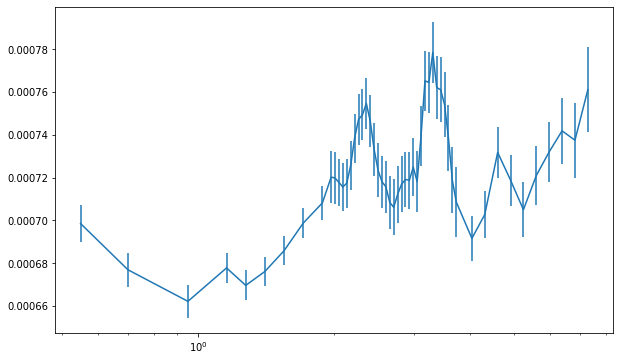

In [17]:
# In helper.py
visualise_spectrum(spec_matrix[1])

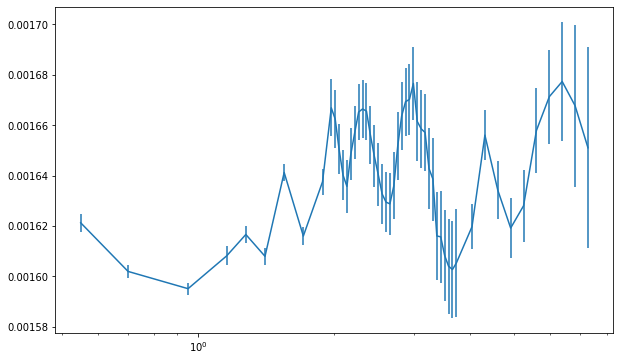

In [18]:
## lets look at another one - In helper.py
visualise_spectrum(spec_matrix[2])

# Visualising a single spectrum

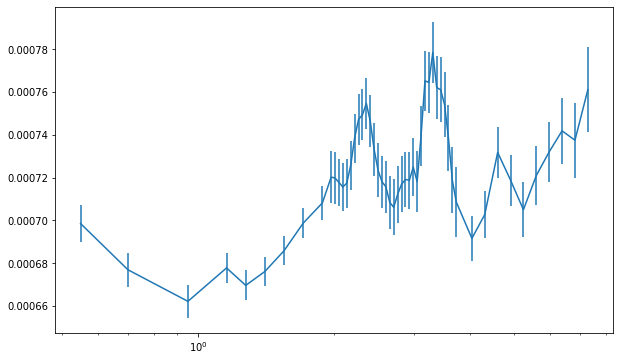

In [19]:
# In helper.py
visualise_spectrum(spec_matrix[1])

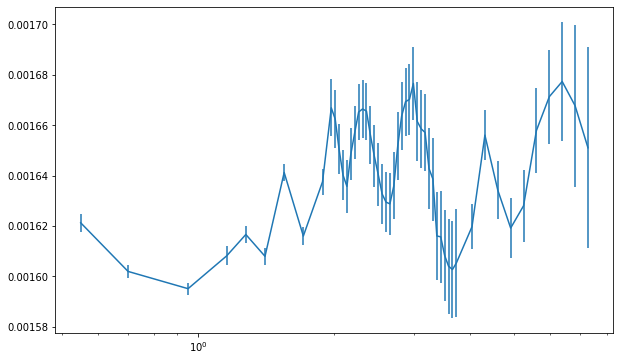

In [20]:
## lets look at another one
visualise_spectrum(spec_matrix[2])

it is immediately apparent that the average transit depth between two spectra can change for an order of magnitude difference. The magnitude of the uncertainty can also change accordingly ( and is a function of the planetary system, brightness of the host star and instrument response function). 

## Pre-processing

### Settings

In [21]:
repeat = 5
N = len(spec_matrix[:,0,0]) 
print(N)
# train on the first 5000 data instances

91392


We can safely discard wlgrid (wavelength grid) and wlwidth (width of wavelength) since they are unchanged in the dataset

In [22]:
## extract the noise
noise = spec_matrix[:N,:,2]
## We will incorporate the noise profile into the observed spectrum by treating the noise as Gaussian noise.
spectra = spec_matrix[:N,:,1]
wl_channels = len(spec_matrix[0,:,0])

### Augment the dataset with noise (create multiple instances)
Observational noise from Ariel forms an important part of the challenge, any model must recognise that the observation are not absolute measurement and could vary (according to the uncertainty), as that will affect the uncertainty associated with our atmospheric targets. Here we try to incorporate these information by augmenting the data with the mean noise.

In [23]:
aug_spectra = augment_data_with_noise(spectra, noise, repeat)

In [24]:
# len(axis[0]) == number of planets you are looking at (Here ALL 91,392)
# len(axis[1]) == number of spectra values now with added random noise (52)
aug_spectra.shape

(456960, 52)

In [25]:
aug_spectra[:5,:2]

array([[0.0016961 , 0.00145011],
       [0.00074769, 0.00074828],
       [0.00164459, 0.00168076],
       [0.00926213, 0.00922471],
       [0.00057042, 0.00067766]])

### Standardise the data

In [26]:
## standardise the input using global mean and stdev
global_mean = np.mean(spectra)
global_std = np.std(spectra)
std_aug_spectra = standardise(aug_spectra, global_mean, global_std)
std_aug_spectra = std_aug_spectra.reshape(-1, wl_channels)

### Add additional features - radius of the star and the planet
Most of the time we know something about the planetary system before we even attempt to make an observation (we cant just point randomly with a multi-million euros instrument!). Some of these auxillary data may be useful for retrieval, here we are only using the radius of the star and the planet.

In [27]:
## add Rstar and Rplanet
radii = aux_training_data[['star_radius_m', 'planet_radius_m']]
## we would prefer to use Rsol and Rjup 
radii['star_radius'] = radii['star_radius_m']/RSOL
radii['planet_radius'] = radii['planet_radius_m']/RJUP
radii = radii.drop(['star_radius_m', 'planet_radius_m'],axis=1)
radii = radii.iloc[:N, :]

<ipython-input-27-a44157462eca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radii['star_radius'] = radii['star_radius_m']/RSOL
<ipython-input-27-a44157462eca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radii['planet_radius'] = radii['planet_radius_m']/RJUP


In [28]:
## standardise
mean_radii = radii.mean()
stdev = radii.std()
std_radii= standardise(radii, mean_radii, stdev)
std_aug_radii = np.tile(std_radii.values,(repeat,1))

### augment target and standardise the output
We are asking the model to provide estimates for 6 atmospheric targets. In this example will be performing a supervised learning task. 

In [29]:
target_labels = ['planet_temp','log_H2O','log_CO2','log_CH4','log_CO','log_NH3']
targets = soft_label_data.iloc[:N][target_labels]
num_targets = targets.shape[1]
targets_mean = targets.mean()
targets_std = targets.std()
std_targets = standardise(targets, targets_mean, targets_std)

std_aug_targets = np.tile(std_targets.values,(repeat,1))

# Setup network


### hyperparameter settings


In [30]:
batch_size= 32
lr= 1e-3
epochs = 10
filters = [32,64,128]
dropout = 0.1
# number of examples to generate in test time
N_samples = 1000

We followed [Yip et al.](https://iopscience.iop.org/article/10.3847/1538-3881/ac1744>) and adopted a simple CNN structure and loss function. 


In [31]:
model = MC_Convtrainer(wl_channels,num_targets,dropout,filters)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 52)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 52, 1)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 50, 32)       128         ['reshape[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 32)       3104        ['conv1d[0][0]']                 
                                                                                              

### Train-test split + shuffling

In [33]:
ind = np.random.rand(len(std_aug_spectra)) < 0.8
x_train_spectra, x_train_radii,y_train = std_aug_spectra[ind],std_aug_radii[ind],std_aug_targets[ind]
x_valid_spectra, x_valid_radii,y_valid = std_aug_spectra[~ind],std_aug_radii[~ind],std_aug_targets[~ind]



### Compile model and Train!

In [34]:
## compile model and run
model.compile(
    optimizer=keras.optimizers.Adam(lr),
    loss='mse',)
model.fit([x_train_spectra,x_train_radii], 
          y_train, 
          validation_data=([x_valid_spectra, x_valid_radii],y_valid),
          batch_size=batch_size, 
          epochs=epochs, 
          shuffle=False,)


Epoch 1/10
11447/11447 [==============================] - 170s 15ms/step - loss: 0.9054 - val_loss: 0.9023
Epoch 2/10
11447/11447 [==============================] - 151s 13ms/step - loss: 0.9039 - val_loss: 0.9018
Epoch 3/10
11447/11447 [==============================] - 142s 12ms/step - loss: 0.9023 - val_loss: 0.9015
Epoch 4/10
11447/11447 [==============================] - 147s 13ms/step - loss: 0.9018 - val_loss: 0.9005
Epoch 5/10
11447/11447 [==============================] - 160s 14ms/step - loss: 0.9011 - val_loss: 0.9001
Epoch 6/10
11447/11447 [==============================] - 173s 15ms/step - loss: 0.8025 - val_loss: 0.5682
Epoch 7/10
11447/11447 [==============================] - 139s 12ms/step - loss: 0.5287 - val_loss: 0.5059
Epoch 8/10
11447/11447 [==============================] - 139s 12ms/step - loss: 0.4897 - val_loss: 0.4842
Epoch 9/10
11447/11447 [==============================] - 140s 12ms/step - loss: 0.4726 - val_loss: 0.4647
Epoch 10/10
11447/11447 [============

## Read test data

In [35]:
spec_test_data = h5py.File(os.path.join(test_path,'SpectralData.hdf5'),"r")
aux_test_data = pd.read_csv(os.path.join(test_path,'AuxillaryTable.csv'))

In [36]:
test_spec_matrix = to_observed_matrix(spec_test_data,aux_test_data )

### same pre-processing as before...

In [37]:
std_test_spectra = standardise(test_spec_matrix[:,:,1], global_mean, global_std)


In [38]:
test_radii = aux_test_data[['star_radius_m', 'planet_radius_m']]
## we would prefer to use Rsol and Rjup 
test_radii['star_radius'] = test_radii['star_radius_m']/RSOL
test_radii['planet_radius'] = test_radii['planet_radius_m']/RJUP
test_radii = test_radii.drop(['star_radius_m', 'planet_radius_m'],axis=1)

std_test_radii= standardise(test_radii, mean_radii, stdev)


<ipython-input-38-6aeda4a94a08>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_radii['star_radius'] = test_radii['star_radius_m']/RSOL
<ipython-input-38-6aeda4a94a08>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_radii['planet_radius'] = test_radii['planet_radius_m']/RJUP


## Predict

In [39]:
instances = N_samples
y_pred_distribution = np.zeros((instances, len(std_test_spectra), num_targets ))
for i in tqdm(range(instances)):
    y_pred = model.predict([std_test_spectra,test_radii])
    y_pred_distribution[i] += y_pred


  0%|          | 0/1000 [00:00<?, ?it/s]

16/16 [==============================] - 0s 4ms/step


  0%|          | 1/1000 [00:00<06:24,  2.60it/s]

16/16 [==============================] - 0s 3ms/step


  0%|          | 2/1000 [00:00<05:02,  3.30it/s]

16/16 [==============================] - 0s 3ms/step


  0%|          | 3/1000 [00:00<04:04,  4.07it/s]

16/16 [==============================] - 0s 4ms/step


  0%|          | 4/1000 [00:00<03:25,  4.86it/s]

16/16 [==============================] - 0s 3ms/step


  0%|          | 5/1000 [00:00<02:57,  5.61it/s]

16/16 [==============================] - 0s 4ms/step


  1%|          | 6/1000 [00:00<02:37,  6.30it/s]

16/16 [==============================] - 0s 4ms/step


  1%|          | 7/1000 [00:01<02:23,  6.90it/s]

16/16 [==============================] - 0s 4ms/step


  1%|          | 8/1000 [00:01<02:15,  7.34it/s]

16/16 [==============================] - 0s 4ms/step


  1%|          | 9/1000 [00:01<02:08,  7.68it/s]

16/16 [==============================] - 0s 4ms/step


  1%|          | 10/1000 [00:01<02:07,  7.78it/s]

16/16 [==============================] - 0s 3ms/step


  1%|          | 11/1000 [00:01<02:01,  8.11it/s]

16/16 [==============================] - 0s 3ms/step


  1%|          | 12/1000 [00:01<01:58,  8.35it/s]

16/16 [==============================] - 0s 4ms/step


  1%|▏         | 13/1000 [00:01<01:59,  8.25it/s]

16/16 [==============================] - 0s 4ms/step


  1%|▏         | 14/1000 [00:01<02:00,  8.20it/s]

16/16 [==============================] - 0s 4ms/step


  2%|▏         | 15/1000 [00:02<01:57,  8.39it/s]

16/16 [==============================] - 0s 4ms/step


  2%|▏         | 16/1000 [00:02<01:56,  8.48it/s]

16/16 [==============================] - 0s 4ms/step


  2%|▏         | 17/1000 [00:02<01:54,  8.60it/s]

16/16 [==============================] - 0s 4ms/step


  2%|▏         | 18/1000 [00:02<01:52,  8.70it/s]

16/16 [==============================] - 0s 4ms/step


  2%|▏         | 19/1000 [00:02<01:53,  8.61it/s]

16/16 [==============================] - 0s 4ms/step


  2%|▏         | 20/1000 [00:02<01:52,  8.70it/s]

16/16 [==============================] - 0s 3ms/step


  2%|▏         | 21/1000 [00:02<01:51,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


  2%|▏         | 22/1000 [00:02<01:54,  8.58it/s]

16/16 [==============================] - 0s 3ms/step


  2%|▏         | 23/1000 [00:02<01:52,  8.70it/s]

16/16 [==============================] - 0s 3ms/step


  2%|▏         | 24/1000 [00:03<01:50,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


  2%|▎         | 25/1000 [00:03<01:49,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


  3%|▎         | 26/1000 [00:03<01:49,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


  3%|▎         | 27/1000 [00:03<01:49,  8.92it/s]

16/16 [==============================] - 0s 4ms/step


  3%|▎         | 28/1000 [00:03<01:50,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


  3%|▎         | 29/1000 [00:03<01:49,  8.87it/s]

16/16 [==============================] - 0s 4ms/step


  3%|▎         | 30/1000 [00:03<01:49,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


  3%|▎         | 31/1000 [00:03<01:48,  8.93it/s]

16/16 [==============================] - 0s 4ms/step


  3%|▎         | 32/1000 [00:03<01:48,  8.94it/s]

16/16 [==============================] - 0s 4ms/step


  3%|▎         | 33/1000 [00:04<01:48,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


  3%|▎         | 34/1000 [00:04<01:49,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


  4%|▎         | 35/1000 [00:04<01:50,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


  4%|▎         | 36/1000 [00:04<01:49,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


  4%|▎         | 37/1000 [00:04<01:48,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


  4%|▍         | 38/1000 [00:04<01:50,  8.73it/s]

16/16 [==============================] - 0s 4ms/step


  4%|▍         | 39/1000 [00:04<01:50,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


  4%|▍         | 40/1000 [00:04<01:49,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


  4%|▍         | 41/1000 [00:04<01:48,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


  4%|▍         | 42/1000 [00:05<01:48,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


  4%|▍         | 43/1000 [00:05<01:47,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


  4%|▍         | 44/1000 [00:05<01:47,  8.92it/s]

16/16 [==============================] - 0s 4ms/step


  4%|▍         | 45/1000 [00:05<01:47,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


  5%|▍         | 46/1000 [00:05<01:46,  8.93it/s]

16/16 [==============================] - 0s 4ms/step


  5%|▍         | 47/1000 [00:05<01:46,  8.93it/s]

16/16 [==============================] - 0s 3ms/step


  5%|▍         | 48/1000 [00:05<01:48,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


  5%|▍         | 49/1000 [00:05<01:47,  8.87it/s]

16/16 [==============================] - 0s 4ms/step


  5%|▌         | 50/1000 [00:05<01:46,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


  5%|▌         | 51/1000 [00:06<01:46,  8.95it/s]

16/16 [==============================] - 0s 4ms/step


  5%|▌         | 52/1000 [00:06<01:46,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


  5%|▌         | 53/1000 [00:06<01:46,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


  5%|▌         | 54/1000 [00:06<01:45,  8.94it/s]

16/16 [==============================] - 0s 3ms/step


  6%|▌         | 55/1000 [00:06<01:45,  8.93it/s]

16/16 [==============================] - 0s 4ms/step


  6%|▌         | 56/1000 [00:06<01:46,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


  6%|▌         | 57/1000 [00:06<01:48,  8.72it/s]

16/16 [==============================] - 0s 3ms/step


  6%|▌         | 58/1000 [00:06<01:46,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


  6%|▌         | 59/1000 [00:06<01:46,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


  6%|▌         | 60/1000 [00:07<01:45,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


  6%|▌         | 61/1000 [00:07<01:45,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


  6%|▌         | 62/1000 [00:07<01:45,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


  6%|▋         | 63/1000 [00:07<01:45,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


  6%|▋         | 64/1000 [00:07<01:45,  8.91it/s]

16/16 [==============================] - 0s 4ms/step


  6%|▋         | 65/1000 [00:07<01:45,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


  7%|▋         | 66/1000 [00:07<01:44,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


  7%|▋         | 67/1000 [00:07<01:46,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


  7%|▋         | 68/1000 [00:07<01:45,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


  7%|▋         | 69/1000 [00:08<01:44,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


  7%|▋         | 70/1000 [00:08<01:44,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


  7%|▋         | 71/1000 [00:08<01:44,  8.92it/s]

16/16 [==============================] - 0s 4ms/step


  7%|▋         | 72/1000 [00:08<01:43,  8.94it/s]

16/16 [==============================] - 0s 4ms/step


  7%|▋         | 73/1000 [00:08<01:43,  8.94it/s]

16/16 [==============================] - 0s 4ms/step


  7%|▋         | 74/1000 [00:08<01:44,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


  8%|▊         | 75/1000 [00:08<01:44,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


  8%|▊         | 76/1000 [00:08<01:44,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


  8%|▊         | 77/1000 [00:09<01:45,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


  8%|▊         | 78/1000 [00:09<01:44,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


  8%|▊         | 79/1000 [00:09<01:45,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


  8%|▊         | 80/1000 [00:09<01:44,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


  8%|▊         | 81/1000 [00:09<01:44,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


  8%|▊         | 82/1000 [00:09<01:43,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


  8%|▊         | 83/1000 [00:09<01:42,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


  8%|▊         | 84/1000 [00:09<01:42,  8.94it/s]

16/16 [==============================] - 0s 4ms/step


  8%|▊         | 85/1000 [00:09<01:42,  8.93it/s]

16/16 [==============================] - 0s 4ms/step


  9%|▊         | 86/1000 [00:10<01:43,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


  9%|▊         | 87/1000 [00:10<01:43,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


  9%|▉         | 88/1000 [00:10<01:42,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


  9%|▉         | 89/1000 [00:10<01:41,  8.94it/s]

16/16 [==============================] - 0s 3ms/step


  9%|▉         | 90/1000 [00:10<01:41,  8.97it/s]

16/16 [==============================] - 0s 3ms/step


  9%|▉         | 91/1000 [00:10<01:40,  9.02it/s]

16/16 [==============================] - 0s 3ms/step


  9%|▉         | 92/1000 [00:10<01:40,  9.00it/s]

16/16 [==============================] - 0s 3ms/step


  9%|▉         | 93/1000 [00:10<01:40,  8.99it/s]

16/16 [==============================] - 0s 3ms/step


  9%|▉         | 94/1000 [00:10<01:41,  8.96it/s]

16/16 [==============================] - 0s 4ms/step


 10%|▉         | 95/1000 [00:11<01:41,  8.95it/s]

16/16 [==============================] - 0s 4ms/step


 10%|▉         | 96/1000 [00:11<01:42,  8.78it/s]

16/16 [==============================] - 0s 4ms/step


 10%|▉         | 97/1000 [00:11<01:42,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 10%|▉         | 98/1000 [00:11<01:42,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


 10%|▉         | 99/1000 [00:11<01:43,  8.66it/s]

16/16 [==============================] - 0s 3ms/step


 10%|█         | 100/1000 [00:11<01:43,  8.72it/s]

16/16 [==============================] - 0s 4ms/step


 10%|█         | 101/1000 [00:11<01:42,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 10%|█         | 102/1000 [00:11<01:42,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


 10%|█         | 103/1000 [00:11<01:44,  8.62it/s]

16/16 [==============================] - 0s 3ms/step


 10%|█         | 104/1000 [00:12<01:42,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 10%|█         | 105/1000 [00:12<01:42,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 11%|█         | 106/1000 [00:12<01:43,  8.66it/s]

16/16 [==============================] - 0s 4ms/step


 11%|█         | 107/1000 [00:12<01:42,  8.75it/s]

16/16 [==============================] - 0s 4ms/step


 11%|█         | 108/1000 [00:12<01:41,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 11%|█         | 109/1000 [00:12<01:40,  8.86it/s]

16/16 [==============================] - 0s 4ms/step


 11%|█         | 110/1000 [00:12<01:39,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 11%|█         | 111/1000 [00:12<01:42,  8.71it/s]

16/16 [==============================] - 0s 3ms/step


 11%|█         | 112/1000 [00:12<01:41,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


 11%|█▏        | 113/1000 [00:13<01:40,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 11%|█▏        | 114/1000 [00:13<01:39,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 12%|█▏        | 115/1000 [00:13<01:39,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 12%|█▏        | 116/1000 [00:13<01:40,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 12%|█▏        | 117/1000 [00:13<01:41,  8.72it/s]

16/16 [==============================] - 0s 4ms/step


 12%|█▏        | 118/1000 [00:13<01:40,  8.76it/s]

16/16 [==============================] - 0s 4ms/step


 12%|█▏        | 119/1000 [00:13<01:39,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 12%|█▏        | 120/1000 [00:13<01:39,  8.87it/s]

16/16 [==============================] - 0s 4ms/step


 12%|█▏        | 121/1000 [00:13<01:38,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 12%|█▏        | 122/1000 [00:14<01:38,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 12%|█▏        | 123/1000 [00:14<01:38,  8.91it/s]

16/16 [==============================] - 0s 4ms/step


 12%|█▏        | 124/1000 [00:14<01:38,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 12%|█▎        | 125/1000 [00:14<01:38,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 13%|█▎        | 126/1000 [00:14<01:39,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 13%|█▎        | 127/1000 [00:14<01:39,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 13%|█▎        | 128/1000 [00:14<01:38,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 13%|█▎        | 129/1000 [00:14<01:38,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 13%|█▎        | 130/1000 [00:15<01:38,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 13%|█▎        | 131/1000 [00:15<01:37,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


 13%|█▎        | 132/1000 [00:15<01:37,  8.86it/s]

16/16 [==============================] - 0s 9ms/step


 13%|█▎        | 133/1000 [00:15<02:00,  7.20it/s]

16/16 [==============================] - 0s 3ms/step


 13%|█▎        | 134/1000 [00:15<01:58,  7.29it/s]

16/16 [==============================] - 0s 4ms/step


 14%|█▎        | 135/1000 [00:15<01:53,  7.64it/s]

16/16 [==============================] - 0s 3ms/step


 14%|█▎        | 136/1000 [00:15<01:48,  7.99it/s]

16/16 [==============================] - 0s 3ms/step


 14%|█▎        | 137/1000 [00:15<01:44,  8.27it/s]

16/16 [==============================] - 0s 4ms/step


 14%|█▍        | 138/1000 [00:16<01:41,  8.46it/s]

16/16 [==============================] - 0s 3ms/step


 14%|█▍        | 139/1000 [00:16<01:39,  8.62it/s]

16/16 [==============================] - 0s 3ms/step


 14%|█▍        | 140/1000 [00:16<01:38,  8.69it/s]

16/16 [==============================] - 0s 3ms/step


 14%|█▍        | 141/1000 [00:16<01:37,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 14%|█▍        | 142/1000 [00:16<01:36,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 14%|█▍        | 143/1000 [00:16<01:36,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 14%|█▍        | 144/1000 [00:16<01:36,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 14%|█▍        | 145/1000 [00:16<01:37,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


 15%|█▍        | 146/1000 [00:16<01:36,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 15%|█▍        | 147/1000 [00:17<01:36,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 15%|█▍        | 148/1000 [00:17<01:35,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 15%|█▍        | 149/1000 [00:17<01:35,  8.95it/s]

16/16 [==============================] - 0s 4ms/step


 15%|█▌        | 150/1000 [00:17<01:35,  8.93it/s]

16/16 [==============================] - 0s 4ms/step


 15%|█▌        | 151/1000 [00:17<01:35,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 15%|█▌        | 152/1000 [00:17<01:35,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 15%|█▌        | 153/1000 [00:17<01:35,  8.91it/s]

16/16 [==============================] - 0s 4ms/step


 15%|█▌        | 154/1000 [00:17<01:34,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 16%|█▌        | 155/1000 [00:17<01:36,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 16%|█▌        | 156/1000 [00:18<01:35,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 16%|█▌        | 157/1000 [00:18<01:34,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 16%|█▌        | 158/1000 [00:18<01:37,  8.60it/s]

16/16 [==============================] - 0s 3ms/step


 16%|█▌        | 159/1000 [00:18<01:36,  8.69it/s]

16/16 [==============================] - 0s 3ms/step


 16%|█▌        | 160/1000 [00:18<01:36,  8.73it/s]

16/16 [==============================] - 0s 3ms/step


 16%|█▌        | 161/1000 [00:18<01:35,  8.76it/s]

16/16 [==============================] - 0s 4ms/step


 16%|█▌        | 162/1000 [00:18<01:35,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 16%|█▋        | 163/1000 [00:18<01:34,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 16%|█▋        | 164/1000 [00:18<01:36,  8.66it/s]

16/16 [==============================] - 0s 4ms/step


 16%|█▋        | 165/1000 [00:19<01:37,  8.58it/s]

16/16 [==============================] - 0s 3ms/step


 17%|█▋        | 166/1000 [00:19<01:36,  8.68it/s]

16/16 [==============================] - 0s 3ms/step


 17%|█▋        | 167/1000 [00:19<01:35,  8.75it/s]

16/16 [==============================] - 0s 4ms/step


 17%|█▋        | 168/1000 [00:19<01:34,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 17%|█▋        | 169/1000 [00:19<01:33,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 17%|█▋        | 170/1000 [00:19<01:33,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 17%|█▋        | 171/1000 [00:19<01:33,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 17%|█▋        | 172/1000 [00:19<01:33,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


 17%|█▋        | 173/1000 [00:19<01:33,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 17%|█▋        | 174/1000 [00:20<01:32,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


 18%|█▊        | 175/1000 [00:20<01:34,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 18%|█▊        | 176/1000 [00:20<01:33,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 18%|█▊        | 177/1000 [00:20<01:32,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 18%|█▊        | 178/1000 [00:20<01:32,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 18%|█▊        | 179/1000 [00:20<01:31,  8.93it/s]

16/16 [==============================] - 0s 3ms/step


 18%|█▊        | 180/1000 [00:20<01:32,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 18%|█▊        | 181/1000 [00:20<01:32,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 18%|█▊        | 182/1000 [00:20<01:31,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 18%|█▊        | 183/1000 [00:21<01:32,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 18%|█▊        | 184/1000 [00:21<01:33,  8.71it/s]

16/16 [==============================] - 0s 4ms/step


 18%|█▊        | 185/1000 [00:21<01:32,  8.78it/s]

16/16 [==============================] - 0s 4ms/step


 19%|█▊        | 186/1000 [00:21<01:36,  8.45it/s]

16/16 [==============================] - 0s 4ms/step


 19%|█▊        | 187/1000 [00:21<01:34,  8.59it/s]

16/16 [==============================] - 0s 4ms/step


 19%|█▉        | 188/1000 [00:21<01:33,  8.65it/s]

16/16 [==============================] - 0s 3ms/step


 19%|█▉        | 189/1000 [00:21<01:32,  8.72it/s]

16/16 [==============================] - 0s 4ms/step


 19%|█▉        | 190/1000 [00:21<01:34,  8.55it/s]

16/16 [==============================] - 0s 3ms/step


 19%|█▉        | 191/1000 [00:22<01:33,  8.62it/s]

16/16 [==============================] - 0s 3ms/step


 19%|█▉        | 192/1000 [00:22<01:33,  8.67it/s]

16/16 [==============================] - 0s 3ms/step


 19%|█▉        | 193/1000 [00:22<01:32,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 19%|█▉        | 194/1000 [00:22<01:33,  8.61it/s]

16/16 [==============================] - 0s 4ms/step


 20%|█▉        | 195/1000 [00:22<01:34,  8.50it/s]

16/16 [==============================] - 0s 4ms/step


 20%|█▉        | 196/1000 [00:22<01:34,  8.52it/s]

16/16 [==============================] - 0s 3ms/step


 20%|█▉        | 197/1000 [00:22<01:32,  8.68it/s]

16/16 [==============================] - 0s 3ms/step


 20%|█▉        | 198/1000 [00:22<01:31,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 20%|█▉        | 199/1000 [00:22<01:30,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 20%|██        | 200/1000 [00:23<01:30,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 20%|██        | 201/1000 [00:23<01:29,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 20%|██        | 202/1000 [00:23<01:29,  8.91it/s]

16/16 [==============================] - 0s 4ms/step


 20%|██        | 203/1000 [00:23<01:29,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 20%|██        | 204/1000 [00:23<01:30,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 20%|██        | 205/1000 [00:23<01:29,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 21%|██        | 206/1000 [00:23<01:29,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 21%|██        | 207/1000 [00:23<01:29,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 21%|██        | 208/1000 [00:23<01:34,  8.40it/s]

16/16 [==============================] - 0s 4ms/step


 21%|██        | 209/1000 [00:24<01:37,  8.14it/s]

16/16 [==============================] - 0s 4ms/step


 21%|██        | 210/1000 [00:24<01:38,  8.01it/s]

16/16 [==============================] - 0s 4ms/step


 21%|██        | 211/1000 [00:24<01:40,  7.84it/s]

16/16 [==============================] - 0s 4ms/step


 21%|██        | 212/1000 [00:24<01:41,  7.77it/s]

16/16 [==============================] - 0s 4ms/step


 21%|██▏       | 213/1000 [00:24<01:43,  7.60it/s]

16/16 [==============================] - 0s 4ms/step


 21%|██▏       | 214/1000 [00:24<01:43,  7.56it/s]

16/16 [==============================] - 0s 4ms/step


 22%|██▏       | 215/1000 [00:24<01:46,  7.34it/s]

16/16 [==============================] - 0s 4ms/step


 22%|██▏       | 216/1000 [00:25<01:41,  7.73it/s]

16/16 [==============================] - 0s 3ms/step


 22%|██▏       | 217/1000 [00:25<01:37,  8.06it/s]

16/16 [==============================] - 0s 4ms/step


 22%|██▏       | 218/1000 [00:25<01:34,  8.28it/s]

16/16 [==============================] - 0s 3ms/step


 22%|██▏       | 219/1000 [00:25<01:32,  8.46it/s]

16/16 [==============================] - 0s 3ms/step


 22%|██▏       | 220/1000 [00:25<01:30,  8.60it/s]

16/16 [==============================] - 0s 3ms/step


 22%|██▏       | 221/1000 [00:25<01:29,  8.70it/s]

16/16 [==============================] - 0s 3ms/step


 22%|██▏       | 222/1000 [00:25<01:28,  8.75it/s]

16/16 [==============================] - 0s 4ms/step


 22%|██▏       | 223/1000 [00:25<01:29,  8.64it/s]

16/16 [==============================] - 0s 4ms/step


 22%|██▏       | 224/1000 [00:25<01:28,  8.73it/s]

16/16 [==============================] - 0s 4ms/step


 22%|██▎       | 225/1000 [00:26<01:28,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 23%|██▎       | 226/1000 [00:26<01:27,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 23%|██▎       | 227/1000 [00:26<01:27,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 23%|██▎       | 228/1000 [00:26<01:27,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 23%|██▎       | 229/1000 [00:26<01:26,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 23%|██▎       | 230/1000 [00:26<01:26,  8.93it/s]

16/16 [==============================] - 0s 4ms/step


 23%|██▎       | 231/1000 [00:26<01:26,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


 23%|██▎       | 232/1000 [00:26<01:26,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


 23%|██▎       | 233/1000 [00:26<01:27,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


 23%|██▎       | 234/1000 [00:27<01:27,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 24%|██▎       | 235/1000 [00:27<01:26,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 24%|██▎       | 236/1000 [00:27<01:26,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


 24%|██▎       | 237/1000 [00:27<01:25,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 24%|██▍       | 238/1000 [00:27<01:25,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 24%|██▍       | 239/1000 [00:27<01:25,  8.92it/s]

16/16 [==============================] - 0s 4ms/step


 24%|██▍       | 240/1000 [00:27<01:25,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 24%|██▍       | 241/1000 [00:27<01:25,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 24%|██▍       | 242/1000 [00:27<01:25,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 24%|██▍       | 243/1000 [00:28<01:25,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 24%|██▍       | 244/1000 [00:28<01:24,  8.93it/s]

16/16 [==============================] - 0s 3ms/step


 24%|██▍       | 245/1000 [00:28<01:24,  8.94it/s]

16/16 [==============================] - 0s 3ms/step


 25%|██▍       | 246/1000 [00:28<01:24,  8.93it/s]

16/16 [==============================] - 0s 3ms/step


 25%|██▍       | 247/1000 [00:28<01:24,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 25%|██▍       | 248/1000 [00:28<01:24,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 25%|██▍       | 249/1000 [00:28<01:24,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 25%|██▌       | 250/1000 [00:28<01:24,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 25%|██▌       | 251/1000 [00:28<01:24,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 25%|██▌       | 252/1000 [00:29<01:25,  8.73it/s]

16/16 [==============================] - 0s 4ms/step


 25%|██▌       | 253/1000 [00:29<01:25,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 25%|██▌       | 254/1000 [00:29<01:24,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 26%|██▌       | 255/1000 [00:29<01:24,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 26%|██▌       | 256/1000 [00:29<01:24,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 26%|██▌       | 257/1000 [00:29<01:23,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 26%|██▌       | 258/1000 [00:29<01:23,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 26%|██▌       | 259/1000 [00:29<01:23,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 26%|██▌       | 260/1000 [00:30<01:23,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 26%|██▌       | 261/1000 [00:30<01:23,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 26%|██▌       | 262/1000 [00:30<01:24,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 26%|██▋       | 263/1000 [00:30<01:23,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 26%|██▋       | 264/1000 [00:30<01:23,  8.86it/s]

16/16 [==============================] - 0s 4ms/step


 26%|██▋       | 265/1000 [00:30<01:22,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 27%|██▋       | 266/1000 [00:30<01:23,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 27%|██▋       | 267/1000 [00:30<01:24,  8.68it/s]

16/16 [==============================] - 0s 4ms/step


 27%|██▋       | 268/1000 [00:30<01:24,  8.69it/s]

16/16 [==============================] - 0s 4ms/step


 27%|██▋       | 269/1000 [00:31<01:24,  8.68it/s]

16/16 [==============================] - 0s 3ms/step


 27%|██▋       | 270/1000 [00:31<01:23,  8.70it/s]

16/16 [==============================] - 0s 4ms/step


 27%|██▋       | 271/1000 [00:31<01:23,  8.73it/s]

16/16 [==============================] - 0s 4ms/step


 27%|██▋       | 272/1000 [00:31<01:25,  8.52it/s]

16/16 [==============================] - 0s 3ms/step


 27%|██▋       | 273/1000 [00:31<01:26,  8.39it/s]

16/16 [==============================] - 0s 4ms/step


 27%|██▋       | 274/1000 [00:31<01:24,  8.56it/s]

16/16 [==============================] - 0s 4ms/step


 28%|██▊       | 275/1000 [00:31<01:24,  8.61it/s]

16/16 [==============================] - 0s 3ms/step


 28%|██▊       | 276/1000 [00:31<01:23,  8.69it/s]

16/16 [==============================] - 0s 4ms/step


 28%|██▊       | 277/1000 [00:31<01:24,  8.61it/s]

16/16 [==============================] - 0s 3ms/step


 28%|██▊       | 278/1000 [00:32<01:23,  8.69it/s]

16/16 [==============================] - 0s 3ms/step


 28%|██▊       | 279/1000 [00:32<01:22,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 28%|██▊       | 280/1000 [00:32<01:21,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 28%|██▊       | 281/1000 [00:32<01:21,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 28%|██▊       | 282/1000 [00:32<01:24,  8.53it/s]

16/16 [==============================] - 0s 4ms/step


 28%|██▊       | 283/1000 [00:32<01:55,  6.20it/s]

16/16 [==============================] - 0s 4ms/step


 28%|██▊       | 284/1000 [00:32<01:45,  6.82it/s]

16/16 [==============================] - 0s 4ms/step


 28%|██▊       | 285/1000 [00:33<01:37,  7.37it/s]

16/16 [==============================] - 0s 3ms/step


 29%|██▊       | 286/1000 [00:33<01:31,  7.82it/s]

16/16 [==============================] - 0s 4ms/step


 29%|██▊       | 287/1000 [00:33<01:27,  8.12it/s]

16/16 [==============================] - 0s 3ms/step


 29%|██▉       | 288/1000 [00:33<01:25,  8.35it/s]

16/16 [==============================] - 0s 3ms/step


 29%|██▉       | 289/1000 [00:33<01:23,  8.54it/s]

16/16 [==============================] - 0s 3ms/step


 29%|██▉       | 290/1000 [00:33<01:21,  8.69it/s]

16/16 [==============================] - 0s 3ms/step


 29%|██▉       | 291/1000 [00:33<01:21,  8.66it/s]

16/16 [==============================] - 0s 3ms/step


 29%|██▉       | 292/1000 [00:33<01:20,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 29%|██▉       | 293/1000 [00:33<01:20,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 29%|██▉       | 294/1000 [00:34<01:20,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 30%|██▉       | 295/1000 [00:34<01:19,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 30%|██▉       | 296/1000 [00:34<01:19,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 30%|██▉       | 297/1000 [00:34<01:18,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 30%|██▉       | 298/1000 [00:34<01:18,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


 30%|██▉       | 299/1000 [00:34<01:18,  8.96it/s]

16/16 [==============================] - 0s 3ms/step


 30%|███       | 300/1000 [00:34<01:19,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 30%|███       | 301/1000 [00:34<01:18,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 30%|███       | 302/1000 [00:34<01:18,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 30%|███       | 303/1000 [00:35<01:18,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 30%|███       | 304/1000 [00:35<01:17,  8.95it/s]

16/16 [==============================] - 0s 3ms/step


 30%|███       | 305/1000 [00:35<01:17,  8.95it/s]

16/16 [==============================] - 0s 3ms/step


 31%|███       | 306/1000 [00:35<01:17,  9.00it/s]

16/16 [==============================] - 0s 3ms/step


 31%|███       | 307/1000 [00:35<01:16,  9.02it/s]

16/16 [==============================] - 0s 4ms/step


 31%|███       | 308/1000 [00:35<01:16,  9.00it/s]

16/16 [==============================] - 0s 3ms/step


 31%|███       | 309/1000 [00:35<01:17,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 31%|███       | 310/1000 [00:35<01:17,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 31%|███       | 311/1000 [00:35<01:17,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 31%|███       | 312/1000 [00:36<01:17,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 31%|███▏      | 313/1000 [00:36<01:17,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 31%|███▏      | 314/1000 [00:36<01:16,  8.93it/s]

16/16 [==============================] - 0s 3ms/step


 32%|███▏      | 315/1000 [00:36<01:16,  8.98it/s]

16/16 [==============================] - 0s 4ms/step


 32%|███▏      | 316/1000 [00:36<01:16,  8.96it/s]

16/16 [==============================] - 0s 3ms/step


 32%|███▏      | 317/1000 [00:36<01:15,  8.99it/s]

16/16 [==============================] - 0s 4ms/step


 32%|███▏      | 318/1000 [00:36<01:17,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 32%|███▏      | 319/1000 [00:36<01:16,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


 32%|███▏      | 320/1000 [00:36<01:16,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 32%|███▏      | 321/1000 [00:37<01:16,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 32%|███▏      | 322/1000 [00:37<01:16,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 32%|███▏      | 323/1000 [00:37<01:15,  8.91it/s]

16/16 [==============================] - 0s 4ms/step


 32%|███▏      | 324/1000 [00:37<01:16,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 32%|███▎      | 325/1000 [00:37<01:15,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 33%|███▎      | 326/1000 [00:37<01:16,  8.86it/s]

16/16 [==============================] - 0s 4ms/step


 33%|███▎      | 327/1000 [00:37<01:16,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 33%|███▎      | 328/1000 [00:37<01:16,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 33%|███▎      | 329/1000 [00:37<01:15,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


 33%|███▎      | 330/1000 [00:38<01:15,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 33%|███▎      | 331/1000 [00:38<01:15,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 33%|███▎      | 332/1000 [00:38<01:14,  8.94it/s]

16/16 [==============================] - 0s 3ms/step


 33%|███▎      | 333/1000 [00:38<01:15,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 33%|███▎      | 334/1000 [00:38<01:15,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 34%|███▎      | 335/1000 [00:38<01:14,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 34%|███▎      | 336/1000 [00:38<01:15,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 34%|███▎      | 337/1000 [00:38<01:15,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 34%|███▍      | 338/1000 [00:38<01:14,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 34%|███▍      | 339/1000 [00:39<01:14,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 34%|███▍      | 340/1000 [00:39<01:14,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 34%|███▍      | 341/1000 [00:39<01:14,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 34%|███▍      | 342/1000 [00:39<01:13,  8.94it/s]

16/16 [==============================] - 0s 4ms/step


 34%|███▍      | 343/1000 [00:39<01:13,  8.93it/s]

16/16 [==============================] - 0s 4ms/step


 34%|███▍      | 344/1000 [00:39<01:13,  8.93it/s]

16/16 [==============================] - 0s 4ms/step


 34%|███▍      | 345/1000 [00:39<01:13,  8.94it/s]

16/16 [==============================] - 0s 4ms/step


 35%|███▍      | 346/1000 [00:39<01:14,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 35%|███▍      | 347/1000 [00:39<01:13,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 35%|███▍      | 348/1000 [00:40<01:13,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 35%|███▍      | 349/1000 [00:40<01:13,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 35%|███▌      | 350/1000 [00:40<01:14,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 35%|███▌      | 351/1000 [00:40<01:13,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 35%|███▌      | 352/1000 [00:40<01:12,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 35%|███▌      | 353/1000 [00:40<01:13,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 35%|███▌      | 354/1000 [00:40<01:12,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 36%|███▌      | 355/1000 [00:40<01:12,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 36%|███▌      | 356/1000 [00:41<01:13,  8.75it/s]

16/16 [==============================] - 0s 4ms/step


 36%|███▌      | 357/1000 [00:41<01:13,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 36%|███▌      | 358/1000 [00:41<01:12,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 36%|███▌      | 359/1000 [00:41<01:12,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 36%|███▌      | 360/1000 [00:41<01:14,  8.57it/s]

16/16 [==============================] - 0s 3ms/step


 36%|███▌      | 361/1000 [00:41<01:13,  8.69it/s]

16/16 [==============================] - 0s 4ms/step


 36%|███▌      | 362/1000 [00:41<01:13,  8.73it/s]

16/16 [==============================] - 0s 3ms/step


 36%|███▋      | 363/1000 [00:41<01:12,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 36%|███▋      | 364/1000 [00:41<01:13,  8.62it/s]

16/16 [==============================] - 0s 3ms/step


 36%|███▋      | 365/1000 [00:42<01:14,  8.53it/s]

16/16 [==============================] - 0s 4ms/step


 37%|███▋      | 366/1000 [00:42<01:13,  8.65it/s]

16/16 [==============================] - 0s 3ms/step


 37%|███▋      | 367/1000 [00:42<01:12,  8.75it/s]

16/16 [==============================] - 0s 4ms/step


 37%|███▋      | 368/1000 [00:42<01:11,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 37%|███▋      | 369/1000 [00:42<01:13,  8.59it/s]

16/16 [==============================] - 0s 3ms/step


 37%|███▋      | 370/1000 [00:42<01:12,  8.68it/s]

16/16 [==============================] - 0s 3ms/step


 37%|███▋      | 371/1000 [00:42<01:11,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


 37%|███▋      | 372/1000 [00:42<01:10,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 37%|███▋      | 373/1000 [00:42<01:10,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 37%|███▋      | 374/1000 [00:43<01:10,  8.93it/s]

16/16 [==============================] - 0s 3ms/step


 38%|███▊      | 375/1000 [00:43<01:11,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 38%|███▊      | 376/1000 [00:43<01:10,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 38%|███▊      | 377/1000 [00:43<01:10,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 38%|███▊      | 378/1000 [00:43<01:10,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 38%|███▊      | 379/1000 [00:43<01:09,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


 38%|███▊      | 380/1000 [00:43<01:10,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 38%|███▊      | 381/1000 [00:43<01:10,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 38%|███▊      | 382/1000 [00:43<01:09,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 38%|███▊      | 383/1000 [00:44<01:09,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 38%|███▊      | 384/1000 [00:44<01:09,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 38%|███▊      | 385/1000 [00:44<01:10,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 39%|███▊      | 386/1000 [00:44<01:09,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 39%|███▊      | 387/1000 [00:44<01:09,  8.86it/s]

16/16 [==============================] - 0s 4ms/step


 39%|███▉      | 388/1000 [00:44<01:08,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 39%|███▉      | 389/1000 [00:44<01:09,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 39%|███▉      | 390/1000 [00:44<01:09,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 39%|███▉      | 391/1000 [00:45<01:08,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 39%|███▉      | 392/1000 [00:45<01:08,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


 39%|███▉      | 393/1000 [00:45<01:08,  8.91it/s]

16/16 [==============================] - 0s 4ms/step


 39%|███▉      | 394/1000 [00:45<01:07,  8.93it/s]

16/16 [==============================] - 0s 4ms/step


 40%|███▉      | 395/1000 [00:45<01:08,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 40%|███▉      | 396/1000 [00:45<01:08,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 40%|███▉      | 397/1000 [00:45<01:07,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 40%|███▉      | 398/1000 [00:45<01:07,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 40%|███▉      | 399/1000 [00:45<01:07,  8.97it/s]

16/16 [==============================] - 0s 3ms/step


 40%|████      | 400/1000 [00:46<01:06,  9.00it/s]

16/16 [==============================] - 0s 3ms/step


 40%|████      | 401/1000 [00:46<01:06,  8.97it/s]

16/16 [==============================] - 0s 3ms/step


 40%|████      | 402/1000 [00:46<01:06,  8.99it/s]

16/16 [==============================] - 0s 3ms/step


 40%|████      | 403/1000 [00:46<01:06,  8.98it/s]

16/16 [==============================] - 0s 3ms/step


 40%|████      | 404/1000 [00:46<01:06,  8.97it/s]

16/16 [==============================] - 0s 4ms/step


 40%|████      | 405/1000 [00:46<01:07,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 41%|████      | 406/1000 [00:46<01:07,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 41%|████      | 407/1000 [00:46<01:06,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 41%|████      | 408/1000 [00:46<01:06,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


 41%|████      | 409/1000 [00:47<01:06,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 41%|████      | 410/1000 [00:47<01:06,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 41%|████      | 411/1000 [00:47<01:05,  8.95it/s]

16/16 [==============================] - 0s 3ms/step


 41%|████      | 412/1000 [00:47<01:05,  8.96it/s]

16/16 [==============================] - 0s 3ms/step


 41%|████▏     | 413/1000 [00:47<01:06,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 41%|████▏     | 414/1000 [00:47<01:06,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 42%|████▏     | 415/1000 [00:47<01:06,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 42%|████▏     | 416/1000 [00:47<01:06,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 42%|████▏     | 417/1000 [00:47<01:05,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 42%|████▏     | 418/1000 [00:48<01:05,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 42%|████▏     | 419/1000 [00:48<01:05,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 42%|████▏     | 420/1000 [00:48<01:05,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 42%|████▏     | 421/1000 [00:48<01:06,  8.66it/s]

16/16 [==============================] - 0s 3ms/step


 42%|████▏     | 422/1000 [00:48<01:06,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 42%|████▏     | 423/1000 [00:48<01:05,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 42%|████▏     | 424/1000 [00:48<01:06,  8.69it/s]

16/16 [==============================] - 0s 3ms/step


 42%|████▎     | 425/1000 [00:48<01:05,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 43%|████▎     | 426/1000 [00:48<01:04,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 43%|████▎     | 427/1000 [00:49<01:05,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 43%|████▎     | 428/1000 [00:49<01:04,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 43%|████▎     | 429/1000 [00:49<01:04,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 43%|████▎     | 430/1000 [00:49<01:04,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 43%|████▎     | 431/1000 [00:49<01:04,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


 43%|████▎     | 432/1000 [00:49<01:03,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 43%|████▎     | 433/1000 [00:49<01:03,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 43%|████▎     | 434/1000 [00:49<01:04,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 44%|████▎     | 435/1000 [00:49<01:04,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 44%|████▎     | 436/1000 [00:50<01:03,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 44%|████▎     | 437/1000 [00:50<01:03,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 44%|████▍     | 438/1000 [00:50<01:03,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 44%|████▍     | 439/1000 [00:50<01:02,  8.93it/s]

16/16 [==============================] - 0s 3ms/step


 44%|████▍     | 440/1000 [00:50<01:02,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 44%|████▍     | 441/1000 [00:50<01:03,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 44%|████▍     | 442/1000 [00:50<01:03,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 44%|████▍     | 443/1000 [00:50<01:03,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 44%|████▍     | 444/1000 [00:50<01:03,  8.70it/s]

16/16 [==============================] - 0s 4ms/step


 44%|████▍     | 445/1000 [00:51<01:03,  8.70it/s]

16/16 [==============================] - 0s 4ms/step


 45%|████▍     | 446/1000 [00:51<01:03,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 45%|████▍     | 447/1000 [00:51<01:02,  8.79it/s]

16/16 [==============================] - 0s 5ms/step


 45%|████▍     | 448/1000 [00:51<01:05,  8.46it/s]

16/16 [==============================] - 0s 4ms/step


 45%|████▍     | 449/1000 [00:51<01:04,  8.56it/s]

16/16 [==============================] - 0s 4ms/step


 45%|████▌     | 450/1000 [00:51<01:03,  8.61it/s]

16/16 [==============================] - 0s 3ms/step


 45%|████▌     | 451/1000 [00:51<01:03,  8.67it/s]

16/16 [==============================] - 0s 4ms/step


 45%|████▌     | 452/1000 [00:51<01:03,  8.57it/s]

16/16 [==============================] - 0s 4ms/step


 45%|████▌     | 453/1000 [00:52<01:03,  8.64it/s]

16/16 [==============================] - 0s 4ms/step


 45%|████▌     | 454/1000 [00:52<01:03,  8.58it/s]

16/16 [==============================] - 0s 3ms/step


 46%|████▌     | 455/1000 [00:52<01:02,  8.71it/s]

16/16 [==============================] - 0s 4ms/step


 46%|████▌     | 456/1000 [00:52<01:02,  8.76it/s]

16/16 [==============================] - 0s 4ms/step


 46%|████▌     | 457/1000 [00:52<01:03,  8.60it/s]

16/16 [==============================] - 0s 3ms/step


 46%|████▌     | 458/1000 [00:52<01:02,  8.68it/s]

16/16 [==============================] - 0s 3ms/step


 46%|████▌     | 459/1000 [00:52<01:01,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 46%|████▌     | 460/1000 [00:52<01:01,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 46%|████▌     | 461/1000 [00:52<01:00,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 46%|████▌     | 462/1000 [00:53<01:00,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 46%|████▋     | 463/1000 [00:53<01:01,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 46%|████▋     | 464/1000 [00:53<01:00,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 46%|████▋     | 465/1000 [00:53<01:00,  8.85it/s]

16/16 [==============================] - 0s 5ms/step


 47%|████▋     | 466/1000 [00:53<01:05,  8.10it/s]

16/16 [==============================] - 0s 4ms/step


 47%|████▋     | 467/1000 [00:53<01:04,  8.28it/s]

16/16 [==============================] - 0s 4ms/step


 47%|████▋     | 468/1000 [00:53<01:03,  8.44it/s]

16/16 [==============================] - 0s 3ms/step


 47%|████▋     | 469/1000 [00:53<01:01,  8.57it/s]

16/16 [==============================] - 0s 3ms/step


 47%|████▋     | 470/1000 [00:53<01:01,  8.64it/s]

16/16 [==============================] - 0s 3ms/step


 47%|████▋     | 471/1000 [00:54<01:00,  8.68it/s]

16/16 [==============================] - 0s 3ms/step


 47%|████▋     | 472/1000 [00:54<01:00,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 47%|████▋     | 473/1000 [00:54<01:00,  8.65it/s]

16/16 [==============================] - 0s 3ms/step


 47%|████▋     | 474/1000 [00:54<01:00,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 48%|████▊     | 475/1000 [00:54<00:59,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 48%|████▊     | 476/1000 [00:54<00:59,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 48%|████▊     | 477/1000 [00:54<00:59,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 48%|████▊     | 478/1000 [00:54<00:59,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 48%|████▊     | 479/1000 [00:55<00:58,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 48%|████▊     | 480/1000 [00:55<00:58,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 48%|████▊     | 481/1000 [00:55<00:58,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 48%|████▊     | 482/1000 [00:55<00:58,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 48%|████▊     | 483/1000 [00:55<00:59,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 48%|████▊     | 484/1000 [00:55<00:58,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 48%|████▊     | 485/1000 [00:55<00:58,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 49%|████▊     | 486/1000 [00:55<00:57,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 49%|████▊     | 487/1000 [00:55<00:57,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 49%|████▉     | 488/1000 [00:56<00:57,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 49%|████▉     | 489/1000 [00:56<00:57,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


 49%|████▉     | 490/1000 [00:56<00:57,  8.93it/s]

16/16 [==============================] - 0s 3ms/step


 49%|████▉     | 491/1000 [00:56<00:56,  8.96it/s]

16/16 [==============================] - 0s 4ms/step


 49%|████▉     | 492/1000 [00:56<00:57,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 49%|████▉     | 493/1000 [00:56<00:57,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 49%|████▉     | 494/1000 [00:56<00:56,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 50%|████▉     | 495/1000 [00:56<00:56,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 50%|████▉     | 496/1000 [00:56<00:56,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 50%|████▉     | 497/1000 [00:57<00:56,  8.87it/s]

16/16 [==============================] - 0s 4ms/step


 50%|████▉     | 498/1000 [00:57<00:56,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 50%|████▉     | 499/1000 [00:57<00:56,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 50%|█████     | 500/1000 [00:57<00:56,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 50%|█████     | 501/1000 [00:57<00:56,  8.87it/s]

16/16 [==============================] - 0s 4ms/step


 50%|█████     | 502/1000 [00:57<00:56,  8.75it/s]

16/16 [==============================] - 0s 4ms/step


 50%|█████     | 503/1000 [00:57<00:56,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 50%|█████     | 504/1000 [00:57<00:56,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 50%|█████     | 505/1000 [00:57<00:55,  8.86it/s]

16/16 [==============================] - 0s 4ms/step


 51%|█████     | 506/1000 [00:58<00:55,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 51%|█████     | 507/1000 [00:58<00:55,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


 51%|█████     | 508/1000 [00:58<00:55,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


 51%|█████     | 509/1000 [00:58<00:55,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 51%|█████     | 510/1000 [00:58<00:54,  8.92it/s]

16/16 [==============================] - 0s 4ms/step


 51%|█████     | 511/1000 [00:58<00:56,  8.69it/s]

16/16 [==============================] - 0s 4ms/step


 51%|█████     | 512/1000 [00:58<00:55,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 51%|█████▏    | 513/1000 [00:58<00:55,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 51%|█████▏    | 514/1000 [00:58<00:54,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 52%|█████▏    | 515/1000 [00:59<00:54,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 52%|█████▏    | 516/1000 [00:59<00:54,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 52%|█████▏    | 517/1000 [00:59<00:54,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 52%|█████▏    | 518/1000 [00:59<00:54,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 52%|█████▏    | 519/1000 [00:59<00:54,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 52%|█████▏    | 520/1000 [00:59<00:53,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 52%|█████▏    | 521/1000 [00:59<00:54,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


 52%|█████▏    | 522/1000 [00:59<00:54,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 52%|█████▏    | 523/1000 [00:59<00:54,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 52%|█████▏    | 524/1000 [01:00<00:53,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 52%|█████▎    | 525/1000 [01:00<00:53,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 53%|█████▎    | 526/1000 [01:00<00:53,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 53%|█████▎    | 527/1000 [01:00<00:53,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 53%|█████▎    | 528/1000 [01:00<00:53,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 53%|█████▎    | 529/1000 [01:00<00:53,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 53%|█████▎    | 530/1000 [01:00<00:52,  8.94it/s]

16/16 [==============================] - 0s 3ms/step


 53%|█████▎    | 531/1000 [01:00<00:53,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 53%|█████▎    | 532/1000 [01:01<00:53,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 53%|█████▎    | 533/1000 [01:01<00:53,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 53%|█████▎    | 534/1000 [01:01<00:52,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 54%|█████▎    | 535/1000 [01:01<00:52,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 54%|█████▎    | 536/1000 [01:01<00:53,  8.61it/s]

16/16 [==============================] - 0s 4ms/step


 54%|█████▎    | 537/1000 [01:01<00:53,  8.68it/s]

16/16 [==============================] - 0s 4ms/step


 54%|█████▍    | 538/1000 [01:01<00:53,  8.61it/s]

16/16 [==============================] - 0s 3ms/step


 54%|█████▍    | 539/1000 [01:01<00:52,  8.71it/s]

16/16 [==============================] - 0s 4ms/step


 54%|█████▍    | 540/1000 [01:01<00:54,  8.50it/s]

16/16 [==============================] - 0s 3ms/step


 54%|█████▍    | 541/1000 [01:02<00:53,  8.55it/s]

16/16 [==============================] - 0s 3ms/step


 54%|█████▍    | 542/1000 [01:02<00:52,  8.68it/s]

16/16 [==============================] - 0s 3ms/step


 54%|█████▍    | 543/1000 [01:02<00:52,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


 54%|█████▍    | 544/1000 [01:02<00:52,  8.76it/s]

16/16 [==============================] - 0s 4ms/step


 55%|█████▍    | 545/1000 [01:02<00:52,  8.59it/s]

16/16 [==============================] - 0s 4ms/step


 55%|█████▍    | 546/1000 [01:02<00:52,  8.64it/s]

16/16 [==============================] - 0s 3ms/step


 55%|█████▍    | 547/1000 [01:02<00:51,  8.72it/s]

16/16 [==============================] - 0s 3ms/step


 55%|█████▍    | 548/1000 [01:02<00:51,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 55%|█████▍    | 549/1000 [01:02<00:51,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 55%|█████▌    | 550/1000 [01:03<00:51,  8.71it/s]

16/16 [==============================] - 0s 3ms/step


 55%|█████▌    | 551/1000 [01:03<00:51,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 55%|█████▌    | 552/1000 [01:03<00:50,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 55%|█████▌    | 553/1000 [01:03<00:50,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 55%|█████▌    | 554/1000 [01:03<00:50,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 56%|█████▌    | 555/1000 [01:03<00:50,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 56%|█████▌    | 556/1000 [01:03<00:50,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 56%|█████▌    | 557/1000 [01:03<00:50,  8.86it/s]

16/16 [==============================] - 0s 4ms/step


 56%|█████▌    | 558/1000 [01:03<00:49,  8.87it/s]

16/16 [==============================] - 0s 4ms/step


 56%|█████▌    | 559/1000 [01:04<00:49,  8.86it/s]

16/16 [==============================] - 0s 4ms/step


 56%|█████▌    | 560/1000 [01:04<00:50,  8.64it/s]

16/16 [==============================] - 0s 3ms/step


 56%|█████▌    | 561/1000 [01:04<00:50,  8.72it/s]

16/16 [==============================] - 0s 3ms/step


 56%|█████▌    | 562/1000 [01:04<00:49,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 56%|█████▋    | 563/1000 [01:04<00:49,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 56%|█████▋    | 564/1000 [01:04<00:49,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 56%|█████▋    | 565/1000 [01:04<00:49,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 57%|█████▋    | 566/1000 [01:04<00:49,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 57%|█████▋    | 567/1000 [01:04<00:49,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 57%|█████▋    | 568/1000 [01:05<00:49,  8.78it/s]

16/16 [==============================] - 0s 4ms/step


 57%|█████▋    | 569/1000 [01:05<00:48,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 57%|█████▋    | 570/1000 [01:05<00:49,  8.72it/s]

16/16 [==============================] - 0s 4ms/step


 57%|█████▋    | 571/1000 [01:05<00:48,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 57%|█████▋    | 572/1000 [01:05<00:48,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 57%|█████▋    | 573/1000 [01:05<00:48,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 57%|█████▋    | 574/1000 [01:05<00:48,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 57%|█████▊    | 575/1000 [01:05<00:47,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 58%|█████▊    | 576/1000 [01:06<00:48,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 58%|█████▊    | 577/1000 [01:06<00:47,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 58%|█████▊    | 578/1000 [01:06<00:47,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 58%|█████▊    | 579/1000 [01:06<00:47,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 58%|█████▊    | 580/1000 [01:06<00:48,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


 58%|█████▊    | 581/1000 [01:06<00:47,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 58%|█████▊    | 582/1000 [01:06<00:47,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 58%|█████▊    | 583/1000 [01:06<00:47,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 58%|█████▊    | 584/1000 [01:06<00:47,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 58%|█████▊    | 585/1000 [01:07<00:47,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 59%|█████▊    | 586/1000 [01:07<00:46,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 59%|█████▊    | 587/1000 [01:07<00:46,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 59%|█████▉    | 588/1000 [01:07<00:46,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 59%|█████▉    | 589/1000 [01:07<00:46,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 59%|█████▉    | 590/1000 [01:07<00:46,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 59%|█████▉    | 591/1000 [01:07<00:45,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 59%|█████▉    | 592/1000 [01:07<00:45,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


 59%|█████▉    | 593/1000 [01:07<00:45,  8.91it/s]

16/16 [==============================] - 0s 4ms/step


 59%|█████▉    | 594/1000 [01:08<00:46,  8.81it/s]

16/16 [==============================] - 0s 5ms/step


 60%|█████▉    | 595/1000 [01:08<00:49,  8.22it/s]

16/16 [==============================] - 0s 4ms/step


 60%|█████▉    | 596/1000 [01:08<00:48,  8.32it/s]

16/16 [==============================] - 0s 3ms/step


 60%|█████▉    | 597/1000 [01:08<00:47,  8.50it/s]

16/16 [==============================] - 0s 4ms/step


 60%|█████▉    | 598/1000 [01:08<00:46,  8.63it/s]

16/16 [==============================] - 0s 4ms/step


 60%|█████▉    | 599/1000 [01:08<00:47,  8.53it/s]

16/16 [==============================] - 0s 4ms/step


 60%|██████    | 600/1000 [01:08<00:46,  8.64it/s]

16/16 [==============================] - 0s 3ms/step


 60%|██████    | 601/1000 [01:08<00:45,  8.73it/s]

16/16 [==============================] - 0s 3ms/step


 60%|██████    | 602/1000 [01:08<00:45,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 60%|██████    | 603/1000 [01:09<00:45,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 60%|██████    | 604/1000 [01:09<00:44,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 60%|██████    | 605/1000 [01:09<00:45,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 61%|██████    | 606/1000 [01:09<00:44,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 61%|██████    | 607/1000 [01:09<00:44,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 61%|██████    | 608/1000 [01:09<00:45,  8.70it/s]

16/16 [==============================] - 0s 3ms/step


 61%|██████    | 609/1000 [01:09<00:44,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 61%|██████    | 610/1000 [01:09<00:44,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 61%|██████    | 611/1000 [01:10<00:44,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 61%|██████    | 612/1000 [01:10<00:43,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 61%|██████▏   | 613/1000 [01:10<00:43,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 61%|██████▏   | 614/1000 [01:10<00:43,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 62%|██████▏   | 615/1000 [01:10<00:43,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 62%|██████▏   | 616/1000 [01:10<00:43,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 62%|██████▏   | 617/1000 [01:10<00:43,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 62%|██████▏   | 618/1000 [01:10<00:43,  8.68it/s]

16/16 [==============================] - 0s 3ms/step


 62%|██████▏   | 619/1000 [01:10<00:43,  8.78it/s]

16/16 [==============================] - 0s 4ms/step


 62%|██████▏   | 620/1000 [01:11<00:43,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 62%|██████▏   | 621/1000 [01:11<00:43,  8.72it/s]

16/16 [==============================] - 0s 4ms/step


 62%|██████▏   | 622/1000 [01:11<00:43,  8.71it/s]

16/16 [==============================] - 0s 4ms/step


 62%|██████▏   | 623/1000 [01:11<00:43,  8.58it/s]

16/16 [==============================] - 0s 3ms/step


 62%|██████▏   | 624/1000 [01:11<00:44,  8.39it/s]

16/16 [==============================] - 0s 4ms/step


 62%|██████▎   | 625/1000 [01:11<00:44,  8.50it/s]

16/16 [==============================] - 0s 3ms/step


 63%|██████▎   | 626/1000 [01:11<00:43,  8.50it/s]

16/16 [==============================] - 0s 4ms/step


 63%|██████▎   | 627/1000 [01:11<00:43,  8.62it/s]

16/16 [==============================] - 0s 4ms/step


 63%|██████▎   | 628/1000 [01:11<00:44,  8.39it/s]

16/16 [==============================] - 0s 4ms/step


 63%|██████▎   | 629/1000 [01:12<00:43,  8.54it/s]

16/16 [==============================] - 0s 3ms/step


 63%|██████▎   | 630/1000 [01:12<00:42,  8.66it/s]

16/16 [==============================] - 0s 4ms/step


 63%|██████▎   | 631/1000 [01:12<00:42,  8.72it/s]

16/16 [==============================] - 0s 4ms/step


 63%|██████▎   | 632/1000 [01:12<00:41,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 63%|██████▎   | 633/1000 [01:12<00:42,  8.62it/s]

16/16 [==============================] - 0s 3ms/step


 63%|██████▎   | 634/1000 [01:12<00:42,  8.67it/s]

16/16 [==============================] - 0s 4ms/step


 64%|██████▎   | 635/1000 [01:12<00:41,  8.72it/s]

16/16 [==============================] - 0s 3ms/step


 64%|██████▎   | 636/1000 [01:12<00:41,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 64%|██████▎   | 637/1000 [01:13<00:41,  8.69it/s]

16/16 [==============================] - 0s 4ms/step


 64%|██████▍   | 638/1000 [01:13<00:41,  8.78it/s]

16/16 [==============================] - 0s 4ms/step


 64%|██████▍   | 639/1000 [01:13<00:40,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 64%|██████▍   | 640/1000 [01:13<00:40,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 64%|██████▍   | 641/1000 [01:13<00:40,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 64%|██████▍   | 642/1000 [01:13<00:40,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 64%|██████▍   | 643/1000 [01:13<00:40,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 64%|██████▍   | 644/1000 [01:13<00:41,  8.67it/s]

16/16 [==============================] - 0s 3ms/step


 64%|██████▍   | 645/1000 [01:13<00:40,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 65%|██████▍   | 646/1000 [01:14<00:40,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 65%|██████▍   | 647/1000 [01:14<00:40,  8.67it/s]

16/16 [==============================] - 0s 4ms/step


 65%|██████▍   | 648/1000 [01:14<00:40,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 65%|██████▍   | 649/1000 [01:14<00:39,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 65%|██████▌   | 650/1000 [01:14<00:39,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 65%|██████▌   | 651/1000 [01:14<00:39,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 65%|██████▌   | 652/1000 [01:14<00:39,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 65%|██████▌   | 653/1000 [01:14<00:39,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 65%|██████▌   | 654/1000 [01:14<00:39,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 66%|██████▌   | 655/1000 [01:15<00:38,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 66%|██████▌   | 656/1000 [01:15<00:39,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 66%|██████▌   | 657/1000 [01:15<00:38,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 66%|██████▌   | 658/1000 [01:15<00:38,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 66%|██████▌   | 659/1000 [01:15<00:39,  8.73it/s]

16/16 [==============================] - 0s 4ms/step


 66%|██████▌   | 660/1000 [01:15<00:38,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 66%|██████▌   | 661/1000 [01:15<00:38,  8.76it/s]

16/16 [==============================] - 0s 4ms/step


 66%|██████▌   | 662/1000 [01:15<00:38,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 66%|██████▋   | 663/1000 [01:15<00:38,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 66%|██████▋   | 664/1000 [01:16<00:38,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 66%|██████▋   | 665/1000 [01:16<00:37,  8.90it/s]

16/16 [==============================] - 0s 3ms/step


 67%|██████▋   | 666/1000 [01:16<00:38,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


 67%|██████▋   | 667/1000 [01:16<00:37,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 67%|██████▋   | 668/1000 [01:16<00:37,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 67%|██████▋   | 669/1000 [01:16<00:37,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 67%|██████▋   | 670/1000 [01:16<00:37,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 67%|██████▋   | 671/1000 [01:16<00:36,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 67%|██████▋   | 672/1000 [01:16<00:37,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 67%|██████▋   | 673/1000 [01:17<00:37,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 67%|██████▋   | 674/1000 [01:17<00:36,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 68%|██████▊   | 675/1000 [01:17<00:36,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 68%|██████▊   | 676/1000 [01:17<00:37,  8.72it/s]

16/16 [==============================] - 0s 3ms/step


 68%|██████▊   | 677/1000 [01:17<00:36,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 68%|██████▊   | 678/1000 [01:17<00:36,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 68%|██████▊   | 679/1000 [01:17<00:36,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 68%|██████▊   | 680/1000 [01:17<00:36,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 68%|██████▊   | 681/1000 [01:17<00:36,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 68%|██████▊   | 682/1000 [01:18<00:35,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 68%|██████▊   | 683/1000 [01:18<00:35,  8.86it/s]

16/16 [==============================] - 0s 4ms/step


 68%|██████▊   | 684/1000 [01:18<00:36,  8.76it/s]

16/16 [==============================] - 0s 4ms/step


 68%|██████▊   | 685/1000 [01:18<00:37,  8.47it/s]

16/16 [==============================] - 0s 4ms/step


 69%|██████▊   | 686/1000 [01:18<00:36,  8.52it/s]

16/16 [==============================] - 0s 4ms/step


 69%|██████▊   | 687/1000 [01:18<00:37,  8.41it/s]

16/16 [==============================] - 0s 4ms/step


 69%|██████▉   | 688/1000 [01:18<00:37,  8.39it/s]

16/16 [==============================] - 0s 4ms/step


 69%|██████▉   | 689/1000 [01:18<00:37,  8.31it/s]

16/16 [==============================] - 0s 4ms/step


 69%|██████▉   | 690/1000 [01:19<00:37,  8.21it/s]

16/16 [==============================] - 0s 4ms/step


 69%|██████▉   | 691/1000 [01:19<00:37,  8.23it/s]

16/16 [==============================] - 0s 4ms/step


 69%|██████▉   | 692/1000 [01:19<00:38,  8.03it/s]

16/16 [==============================] - 0s 3ms/step


 69%|██████▉   | 693/1000 [01:19<00:37,  8.26it/s]

16/16 [==============================] - 0s 3ms/step


 69%|██████▉   | 694/1000 [01:19<00:36,  8.46it/s]

16/16 [==============================] - 0s 3ms/step


 70%|██████▉   | 695/1000 [01:19<00:35,  8.48it/s]

16/16 [==============================] - 0s 3ms/step


 70%|██████▉   | 696/1000 [01:19<00:43,  6.97it/s]

16/16 [==============================] - 0s 3ms/step


 70%|██████▉   | 697/1000 [01:19<00:41,  7.38it/s]

16/16 [==============================] - 0s 3ms/step


 70%|██████▉   | 698/1000 [01:20<00:38,  7.78it/s]

16/16 [==============================] - 0s 4ms/step


 70%|██████▉   | 699/1000 [01:20<00:37,  8.05it/s]

16/16 [==============================] - 0s 3ms/step


 70%|███████   | 700/1000 [01:20<00:36,  8.27it/s]

16/16 [==============================] - 0s 3ms/step


 70%|███████   | 701/1000 [01:20<00:35,  8.43it/s]

16/16 [==============================] - 0s 4ms/step


 70%|███████   | 702/1000 [01:20<00:34,  8.52it/s]

16/16 [==============================] - 0s 3ms/step


 70%|███████   | 703/1000 [01:20<00:34,  8.56it/s]

16/16 [==============================] - 0s 7ms/step


 70%|███████   | 704/1000 [01:20<00:40,  7.34it/s]

16/16 [==============================] - 0s 4ms/step


 70%|███████   | 705/1000 [01:20<00:38,  7.73it/s]

16/16 [==============================] - 0s 4ms/step


 71%|███████   | 706/1000 [01:21<00:36,  8.04it/s]

16/16 [==============================] - 0s 4ms/step


 71%|███████   | 707/1000 [01:21<00:35,  8.17it/s]

16/16 [==============================] - 0s 3ms/step


 71%|███████   | 708/1000 [01:21<00:34,  8.40it/s]

16/16 [==============================] - 0s 4ms/step


 71%|███████   | 709/1000 [01:21<00:34,  8.45it/s]

16/16 [==============================] - 0s 3ms/step


 71%|███████   | 710/1000 [01:21<00:34,  8.30it/s]

16/16 [==============================] - 0s 3ms/step


 71%|███████   | 711/1000 [01:21<00:34,  8.46it/s]

16/16 [==============================] - 0s 4ms/step


 71%|███████   | 712/1000 [01:21<00:33,  8.48it/s]

16/16 [==============================] - 0s 4ms/step


 71%|███████▏  | 713/1000 [01:21<00:33,  8.60it/s]

16/16 [==============================] - 0s 4ms/step


 71%|███████▏  | 714/1000 [01:22<00:34,  8.34it/s]

16/16 [==============================] - 0s 3ms/step


 72%|███████▏  | 715/1000 [01:22<00:33,  8.51it/s]

16/16 [==============================] - 0s 3ms/step


 72%|███████▏  | 716/1000 [01:22<00:32,  8.65it/s]

16/16 [==============================] - 0s 3ms/step


 72%|███████▏  | 717/1000 [01:22<00:32,  8.71it/s]

16/16 [==============================] - 0s 4ms/step


 72%|███████▏  | 718/1000 [01:22<00:33,  8.54it/s]

16/16 [==============================] - 0s 3ms/step


 72%|███████▏  | 719/1000 [01:22<00:32,  8.58it/s]

16/16 [==============================] - 0s 3ms/step


 72%|███████▏  | 720/1000 [01:22<00:32,  8.65it/s]

16/16 [==============================] - 0s 4ms/step


 72%|███████▏  | 721/1000 [01:22<00:31,  8.73it/s]

16/16 [==============================] - 0s 3ms/step


 72%|███████▏  | 722/1000 [01:22<00:31,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 72%|███████▏  | 723/1000 [01:23<00:31,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 72%|███████▏  | 724/1000 [01:23<00:31,  8.70it/s]

16/16 [==============================] - 0s 4ms/step


 72%|███████▎  | 725/1000 [01:23<00:31,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 73%|███████▎  | 726/1000 [01:23<00:31,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 73%|███████▎  | 727/1000 [01:23<00:30,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 73%|███████▎  | 728/1000 [01:23<00:30,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 73%|███████▎  | 729/1000 [01:23<00:30,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 73%|███████▎  | 730/1000 [01:23<00:30,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 73%|███████▎  | 731/1000 [01:23<00:30,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 73%|███████▎  | 732/1000 [01:24<00:30,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 73%|███████▎  | 733/1000 [01:24<00:30,  8.64it/s]

16/16 [==============================] - 0s 4ms/step


 73%|███████▎  | 734/1000 [01:24<00:30,  8.72it/s]

16/16 [==============================] - 0s 4ms/step


 74%|███████▎  | 735/1000 [01:24<00:30,  8.78it/s]

16/16 [==============================] - 0s 4ms/step


 74%|███████▎  | 736/1000 [01:24<00:30,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 74%|███████▎  | 737/1000 [01:24<00:29,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 74%|███████▍  | 738/1000 [01:24<00:29,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 74%|███████▍  | 739/1000 [01:24<00:29,  8.71it/s]

16/16 [==============================] - 0s 3ms/step


 74%|███████▍  | 740/1000 [01:24<00:29,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


 74%|███████▍  | 741/1000 [01:25<00:29,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 74%|███████▍  | 742/1000 [01:25<00:29,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 74%|███████▍  | 743/1000 [01:25<00:29,  8.73it/s]

16/16 [==============================] - 0s 3ms/step


 74%|███████▍  | 744/1000 [01:25<00:29,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 74%|███████▍  | 745/1000 [01:25<00:28,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 75%|███████▍  | 746/1000 [01:25<00:28,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 75%|███████▍  | 747/1000 [01:25<00:28,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 75%|███████▍  | 748/1000 [01:25<00:28,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 75%|███████▍  | 749/1000 [01:26<00:28,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 75%|███████▌  | 750/1000 [01:26<00:28,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 75%|███████▌  | 751/1000 [01:26<00:28,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 75%|███████▌  | 752/1000 [01:26<00:28,  8.70it/s]

16/16 [==============================] - 0s 3ms/step


 75%|███████▌  | 753/1000 [01:26<00:28,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 75%|███████▌  | 754/1000 [01:26<00:27,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 76%|███████▌  | 755/1000 [01:26<00:27,  8.87it/s]

16/16 [==============================] - 0s 3ms/step


 76%|███████▌  | 756/1000 [01:26<00:27,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 76%|███████▌  | 757/1000 [01:26<00:27,  8.90it/s]

16/16 [==============================] - 0s 4ms/step


 76%|███████▌  | 758/1000 [01:27<00:27,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 76%|███████▌  | 759/1000 [01:27<00:27,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 76%|███████▌  | 760/1000 [01:27<00:27,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 76%|███████▌  | 761/1000 [01:27<00:26,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


 76%|███████▌  | 762/1000 [01:27<00:27,  8.65it/s]

16/16 [==============================] - 0s 3ms/step


 76%|███████▋  | 763/1000 [01:27<00:27,  8.73it/s]

16/16 [==============================] - 0s 4ms/step


 76%|███████▋  | 764/1000 [01:27<00:26,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 76%|███████▋  | 765/1000 [01:27<00:26,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 77%|███████▋  | 766/1000 [01:27<00:26,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 77%|███████▋  | 767/1000 [01:28<00:27,  8.54it/s]

16/16 [==============================] - 0s 4ms/step


 77%|███████▋  | 768/1000 [01:28<00:27,  8.41it/s]

16/16 [==============================] - 0s 4ms/step


 77%|███████▋  | 769/1000 [01:28<00:27,  8.32it/s]

16/16 [==============================] - 0s 4ms/step


 77%|███████▋  | 770/1000 [01:28<00:27,  8.48it/s]

16/16 [==============================] - 0s 4ms/step


 77%|███████▋  | 771/1000 [01:28<00:26,  8.63it/s]

16/16 [==============================] - 0s 4ms/step


 77%|███████▋  | 772/1000 [01:28<00:26,  8.57it/s]

16/16 [==============================] - 0s 3ms/step


 77%|███████▋  | 773/1000 [01:28<00:26,  8.64it/s]

16/16 [==============================] - 0s 3ms/step


 77%|███████▋  | 774/1000 [01:28<00:25,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 78%|███████▊  | 775/1000 [01:28<00:25,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 78%|███████▊  | 776/1000 [01:29<00:25,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 78%|███████▊  | 777/1000 [01:29<00:25,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 78%|███████▊  | 778/1000 [01:29<00:25,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 78%|███████▊  | 779/1000 [01:29<00:24,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 78%|███████▊  | 780/1000 [01:29<00:24,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 78%|███████▊  | 781/1000 [01:29<00:25,  8.72it/s]

16/16 [==============================] - 0s 4ms/step


 78%|███████▊  | 782/1000 [01:29<00:24,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 78%|███████▊  | 783/1000 [01:29<00:24,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 78%|███████▊  | 784/1000 [01:30<00:24,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 78%|███████▊  | 785/1000 [01:30<00:24,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 79%|███████▊  | 786/1000 [01:30<00:24,  8.71it/s]

16/16 [==============================] - 0s 3ms/step


 79%|███████▊  | 787/1000 [01:30<00:25,  8.42it/s]

16/16 [==============================] - 0s 4ms/step


 79%|███████▉  | 788/1000 [01:30<00:25,  8.46it/s]

16/16 [==============================] - 0s 4ms/step


 79%|███████▉  | 789/1000 [01:30<00:24,  8.56it/s]

16/16 [==============================] - 0s 4ms/step


 79%|███████▉  | 790/1000 [01:30<00:24,  8.67it/s]

16/16 [==============================] - 0s 4ms/step


 79%|███████▉  | 791/1000 [01:30<00:24,  8.58it/s]

16/16 [==============================] - 0s 3ms/step


 79%|███████▉  | 792/1000 [01:30<00:23,  8.70it/s]

16/16 [==============================] - 0s 3ms/step


 79%|███████▉  | 793/1000 [01:31<00:23,  8.75it/s]

16/16 [==============================] - 0s 4ms/step


 79%|███████▉  | 794/1000 [01:31<00:23,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 80%|███████▉  | 795/1000 [01:31<00:23,  8.73it/s]

16/16 [==============================] - 0s 3ms/step


 80%|███████▉  | 796/1000 [01:31<00:23,  8.69it/s]

16/16 [==============================] - 0s 4ms/step


 80%|███████▉  | 797/1000 [01:31<00:24,  8.41it/s]

16/16 [==============================] - 0s 4ms/step


 80%|███████▉  | 798/1000 [01:31<00:23,  8.53it/s]

16/16 [==============================] - 0s 4ms/step


 80%|███████▉  | 799/1000 [01:31<00:23,  8.55it/s]

16/16 [==============================] - 0s 4ms/step


 80%|████████  | 800/1000 [01:31<00:23,  8.65it/s]

16/16 [==============================] - 0s 4ms/step


 80%|████████  | 801/1000 [01:31<00:23,  8.38it/s]

16/16 [==============================] - 0s 3ms/step


 80%|████████  | 802/1000 [01:32<00:23,  8.54it/s]

16/16 [==============================] - 0s 3ms/step


 80%|████████  | 803/1000 [01:32<00:22,  8.63it/s]

16/16 [==============================] - 0s 3ms/step


 80%|████████  | 804/1000 [01:32<00:22,  8.70it/s]

16/16 [==============================] - 0s 4ms/step


 80%|████████  | 805/1000 [01:32<00:22,  8.71it/s]

16/16 [==============================] - 0s 4ms/step


 81%|████████  | 806/1000 [01:32<00:22,  8.48it/s]

16/16 [==============================] - 0s 4ms/step


 81%|████████  | 807/1000 [01:32<00:22,  8.56it/s]

16/16 [==============================] - 0s 4ms/step


 81%|████████  | 808/1000 [01:32<00:22,  8.63it/s]

16/16 [==============================] - 0s 4ms/step


 81%|████████  | 809/1000 [01:32<00:21,  8.70it/s]

16/16 [==============================] - 0s 4ms/step


 81%|████████  | 810/1000 [01:33<00:21,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


 81%|████████  | 811/1000 [01:33<00:21,  8.63it/s]

16/16 [==============================] - 0s 3ms/step


 81%|████████  | 812/1000 [01:33<00:21,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


 81%|████████▏ | 813/1000 [01:33<00:21,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 81%|████████▏ | 814/1000 [01:33<00:21,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 82%|████████▏ | 815/1000 [01:33<00:20,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 82%|████████▏ | 816/1000 [01:33<00:20,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 82%|████████▏ | 817/1000 [01:33<00:20,  8.78it/s]

16/16 [==============================] - 0s 4ms/step


 82%|████████▏ | 818/1000 [01:33<00:20,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 82%|████████▏ | 819/1000 [01:34<00:20,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 82%|████████▏ | 820/1000 [01:34<00:20,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 82%|████████▏ | 821/1000 [01:34<00:20,  8.68it/s]

16/16 [==============================] - 0s 3ms/step


 82%|████████▏ | 822/1000 [01:34<00:20,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 82%|████████▏ | 823/1000 [01:34<00:20,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 82%|████████▏ | 824/1000 [01:34<00:19,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 82%|████████▎ | 825/1000 [01:34<00:19,  8.81it/s]

16/16 [==============================] - 0s 3ms/step


 83%|████████▎ | 826/1000 [01:34<00:19,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 83%|████████▎ | 827/1000 [01:34<00:20,  8.56it/s]

16/16 [==============================] - 0s 3ms/step


 83%|████████▎ | 828/1000 [01:35<00:19,  8.63it/s]

16/16 [==============================] - 0s 4ms/step


 83%|████████▎ | 829/1000 [01:35<00:19,  8.67it/s]

16/16 [==============================] - 0s 3ms/step


 83%|████████▎ | 830/1000 [01:35<00:19,  8.65it/s]

16/16 [==============================] - 0s 4ms/step


 83%|████████▎ | 831/1000 [01:35<00:19,  8.71it/s]

16/16 [==============================] - 0s 3ms/step


 83%|████████▎ | 832/1000 [01:35<00:19,  8.78it/s]

16/16 [==============================] - 0s 4ms/step


 83%|████████▎ | 833/1000 [01:35<00:19,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 83%|████████▎ | 834/1000 [01:35<00:18,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 84%|████████▎ | 835/1000 [01:35<00:18,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


 84%|████████▎ | 836/1000 [01:35<00:18,  8.76it/s]

16/16 [==============================] - 0s 4ms/step


 84%|████████▎ | 837/1000 [01:36<00:18,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 84%|████████▍ | 838/1000 [01:36<00:18,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 84%|████████▍ | 839/1000 [01:36<00:18,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 84%|████████▍ | 840/1000 [01:36<00:18,  8.67it/s]

16/16 [==============================] - 0s 4ms/step


 84%|████████▍ | 841/1000 [01:36<00:18,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 84%|████████▍ | 842/1000 [01:36<00:17,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 84%|████████▍ | 843/1000 [01:36<00:17,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 84%|████████▍ | 844/1000 [01:36<00:17,  8.86it/s]

16/16 [==============================] - 0s 4ms/step


 84%|████████▍ | 845/1000 [01:37<00:17,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 85%|████████▍ | 846/1000 [01:37<00:17,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 85%|████████▍ | 847/1000 [01:37<00:17,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 85%|████████▍ | 848/1000 [01:37<00:17,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 85%|████████▍ | 849/1000 [01:37<00:16,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 85%|████████▌ | 850/1000 [01:37<00:17,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 85%|████████▌ | 851/1000 [01:37<00:16,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 85%|████████▌ | 852/1000 [01:37<00:16,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 85%|████████▌ | 853/1000 [01:37<00:16,  8.85it/s]

16/16 [==============================] - 0s 4ms/step


 85%|████████▌ | 854/1000 [01:38<00:16,  8.84it/s]

16/16 [==============================] - 0s 4ms/step


 86%|████████▌ | 855/1000 [01:38<00:16,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 86%|████████▌ | 856/1000 [01:38<00:16,  8.70it/s]

16/16 [==============================] - 0s 4ms/step


 86%|████████▌ | 857/1000 [01:38<00:16,  8.69it/s]

16/16 [==============================] - 0s 3ms/step


 86%|████████▌ | 858/1000 [01:38<00:16,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


 86%|████████▌ | 859/1000 [01:38<00:15,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 86%|████████▌ | 860/1000 [01:38<00:16,  8.73it/s]

16/16 [==============================] - 0s 3ms/step


 86%|████████▌ | 861/1000 [01:38<00:15,  8.79it/s]

16/16 [==============================] - 0s 4ms/step


 86%|████████▌ | 862/1000 [01:38<00:15,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 86%|████████▋ | 863/1000 [01:39<00:15,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 86%|████████▋ | 864/1000 [01:39<00:15,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 86%|████████▋ | 865/1000 [01:39<00:15,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 87%|████████▋ | 866/1000 [01:39<00:15,  8.71it/s]

16/16 [==============================] - 0s 3ms/step


 87%|████████▋ | 867/1000 [01:39<00:15,  8.73it/s]

16/16 [==============================] - 0s 4ms/step


 87%|████████▋ | 868/1000 [01:39<00:15,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 87%|████████▋ | 869/1000 [01:39<00:14,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 87%|████████▋ | 870/1000 [01:39<00:15,  8.61it/s]

16/16 [==============================] - 0s 4ms/step


 87%|████████▋ | 871/1000 [01:39<00:14,  8.69it/s]

16/16 [==============================] - 0s 3ms/step


 87%|████████▋ | 872/1000 [01:40<00:14,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 87%|████████▋ | 873/1000 [01:40<00:14,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 87%|████████▋ | 874/1000 [01:40<00:14,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 88%|████████▊ | 875/1000 [01:40<00:14,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 88%|████████▊ | 876/1000 [01:40<00:14,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 88%|████████▊ | 877/1000 [01:40<00:14,  8.76it/s]

16/16 [==============================] - 0s 4ms/step


 88%|████████▊ | 878/1000 [01:40<00:13,  8.76it/s]

16/16 [==============================] - 0s 4ms/step


 88%|████████▊ | 879/1000 [01:40<00:13,  8.64it/s]

16/16 [==============================] - 0s 4ms/step


 88%|████████▊ | 880/1000 [01:41<00:13,  8.72it/s]

16/16 [==============================] - 0s 4ms/step


 88%|████████▊ | 881/1000 [01:41<00:13,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 88%|████████▊ | 882/1000 [01:41<00:13,  8.71it/s]

16/16 [==============================] - 0s 3ms/step


 88%|████████▊ | 883/1000 [01:41<00:13,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 88%|████████▊ | 884/1000 [01:41<00:13,  8.49it/s]

16/16 [==============================] - 0s 3ms/step


 88%|████████▊ | 885/1000 [01:41<00:13,  8.59it/s]

16/16 [==============================] - 0s 4ms/step


 89%|████████▊ | 886/1000 [01:41<00:13,  8.62it/s]

16/16 [==============================] - 0s 4ms/step


 89%|████████▊ | 887/1000 [01:41<00:13,  8.52it/s]

16/16 [==============================] - 0s 4ms/step


 89%|████████▉ | 888/1000 [01:41<00:13,  8.53it/s]

16/16 [==============================] - 0s 4ms/step


 89%|████████▉ | 889/1000 [01:42<00:13,  8.45it/s]

16/16 [==============================] - 0s 4ms/step


 89%|████████▉ | 890/1000 [01:42<00:12,  8.56it/s]

16/16 [==============================] - 0s 4ms/step


 89%|████████▉ | 891/1000 [01:42<00:12,  8.61it/s]

16/16 [==============================] - 0s 4ms/step


 89%|████████▉ | 892/1000 [01:42<00:12,  8.64it/s]

16/16 [==============================] - 0s 4ms/step


 89%|████████▉ | 893/1000 [01:42<00:12,  8.60it/s]

16/16 [==============================] - 0s 4ms/step


 89%|████████▉ | 894/1000 [01:42<00:12,  8.57it/s]

16/16 [==============================] - 0s 4ms/step


 90%|████████▉ | 895/1000 [01:42<00:12,  8.50it/s]

16/16 [==============================] - 0s 3ms/step


 90%|████████▉ | 896/1000 [01:42<00:12,  8.60it/s]

16/16 [==============================] - 0s 4ms/step


 90%|████████▉ | 897/1000 [01:42<00:11,  8.64it/s]

16/16 [==============================] - 0s 6ms/step


 90%|████████▉ | 898/1000 [01:43<00:13,  7.78it/s]

16/16 [==============================] - 0s 3ms/step


 90%|████████▉ | 899/1000 [01:43<00:13,  7.76it/s]

16/16 [==============================] - 0s 3ms/step


 90%|█████████ | 900/1000 [01:43<00:12,  8.09it/s]

16/16 [==============================] - 0s 3ms/step


 90%|█████████ | 901/1000 [01:43<00:11,  8.33it/s]

16/16 [==============================] - 0s 3ms/step


 90%|█████████ | 902/1000 [01:43<00:11,  8.47it/s]

16/16 [==============================] - 0s 4ms/step


 90%|█████████ | 903/1000 [01:43<00:11,  8.48it/s]

16/16 [==============================] - 0s 4ms/step


 90%|█████████ | 904/1000 [01:43<00:11,  8.54it/s]

16/16 [==============================] - 0s 4ms/step


 90%|█████████ | 905/1000 [01:43<00:11,  8.55it/s]

16/16 [==============================] - 0s 4ms/step


 91%|█████████ | 906/1000 [01:44<00:10,  8.57it/s]

16/16 [==============================] - 0s 3ms/step


 91%|█████████ | 907/1000 [01:44<00:10,  8.66it/s]

16/16 [==============================] - 0s 3ms/step


 91%|█████████ | 908/1000 [01:44<00:10,  8.61it/s]

16/16 [==============================] - 0s 3ms/step


 91%|█████████ | 909/1000 [01:44<00:10,  8.70it/s]

16/16 [==============================] - 0s 3ms/step


 91%|█████████ | 910/1000 [01:44<00:10,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


 91%|█████████ | 911/1000 [01:44<00:10,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 91%|█████████ | 912/1000 [01:44<00:10,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 91%|█████████▏| 913/1000 [01:44<00:10,  8.68it/s]

16/16 [==============================] - 0s 4ms/step


 91%|█████████▏| 914/1000 [01:44<00:09,  8.68it/s]

16/16 [==============================] - 0s 4ms/step


 92%|█████████▏| 915/1000 [01:45<00:09,  8.70it/s]

16/16 [==============================] - 0s 4ms/step


 92%|█████████▏| 916/1000 [01:45<00:09,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 92%|█████████▏| 917/1000 [01:45<00:09,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 92%|█████████▏| 918/1000 [01:45<00:09,  8.68it/s]

16/16 [==============================] - 0s 3ms/step


 92%|█████████▏| 919/1000 [01:45<00:09,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


 92%|█████████▏| 920/1000 [01:45<00:09,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 92%|█████████▏| 921/1000 [01:45<00:08,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 92%|█████████▏| 922/1000 [01:45<00:08,  8.86it/s]

16/16 [==============================] - 0s 3ms/step


 92%|█████████▏| 923/1000 [01:46<00:08,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 92%|█████████▏| 924/1000 [01:46<00:08,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


 92%|█████████▎| 925/1000 [01:46<00:08,  8.77it/s]

16/16 [==============================] - 0s 4ms/step


 93%|█████████▎| 926/1000 [01:46<00:08,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 93%|█████████▎| 927/1000 [01:46<00:08,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 93%|█████████▎| 928/1000 [01:46<00:08,  8.68it/s]

16/16 [==============================] - 0s 4ms/step


 93%|█████████▎| 929/1000 [01:46<00:08,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 93%|█████████▎| 930/1000 [01:46<00:07,  8.77it/s]

16/16 [==============================] - 0s 3ms/step


 93%|█████████▎| 931/1000 [01:46<00:07,  8.80it/s]

16/16 [==============================] - 0s 4ms/step


 93%|█████████▎| 932/1000 [01:47<00:07,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 93%|█████████▎| 933/1000 [01:47<00:07,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 93%|█████████▎| 934/1000 [01:47<00:07,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 94%|█████████▎| 935/1000 [01:47<00:07,  8.84it/s]

16/16 [==============================] - 0s 3ms/step


 94%|█████████▎| 936/1000 [01:47<00:07,  8.88it/s]

16/16 [==============================] - 0s 3ms/step


 94%|█████████▎| 937/1000 [01:47<00:07,  8.89it/s]

16/16 [==============================] - 0s 4ms/step


 94%|█████████▍| 938/1000 [01:47<00:07,  8.70it/s]

16/16 [==============================] - 0s 3ms/step


 94%|█████████▍| 939/1000 [01:47<00:06,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 94%|█████████▍| 940/1000 [01:47<00:06,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 94%|█████████▍| 941/1000 [01:48<00:06,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 94%|█████████▍| 942/1000 [01:48<00:06,  8.82it/s]

16/16 [==============================] - 0s 4ms/step


 94%|█████████▍| 943/1000 [01:48<00:06,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 94%|█████████▍| 944/1000 [01:48<00:06,  8.65it/s]

16/16 [==============================] - 0s 3ms/step


 94%|█████████▍| 945/1000 [01:48<00:06,  8.69it/s]

16/16 [==============================] - 0s 3ms/step


 95%|█████████▍| 946/1000 [01:48<00:06,  8.74it/s]

16/16 [==============================] - 0s 3ms/step


 95%|█████████▍| 947/1000 [01:48<00:06,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 95%|█████████▍| 948/1000 [01:48<00:05,  8.71it/s]

16/16 [==============================] - 0s 4ms/step


 95%|█████████▍| 949/1000 [01:48<00:05,  8.76it/s]

16/16 [==============================] - 0s 3ms/step


 95%|█████████▌| 950/1000 [01:49<00:05,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 95%|█████████▌| 951/1000 [01:49<00:05,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 95%|█████████▌| 952/1000 [01:49<00:05,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 95%|█████████▌| 953/1000 [01:49<00:05,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 95%|█████████▌| 954/1000 [01:49<00:05,  8.80it/s]

16/16 [==============================] - 0s 3ms/step


 96%|█████████▌| 955/1000 [01:49<00:05,  8.78it/s]

16/16 [==============================] - 0s 4ms/step


 96%|█████████▌| 956/1000 [01:49<00:05,  8.74it/s]

16/16 [==============================] - 0s 4ms/step


 96%|█████████▌| 957/1000 [01:49<00:04,  8.65it/s]

16/16 [==============================] - 0s 3ms/step


 96%|█████████▌| 958/1000 [01:50<00:04,  8.75it/s]

16/16 [==============================] - 0s 3ms/step


 96%|█████████▌| 959/1000 [01:50<00:04,  8.83it/s]

16/16 [==============================] - 0s 3ms/step


 96%|█████████▌| 960/1000 [01:50<00:04,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 96%|█████████▌| 961/1000 [01:50<00:04,  8.85it/s]

16/16 [==============================] - 0s 3ms/step


 96%|█████████▌| 962/1000 [01:50<00:04,  8.79it/s]

16/16 [==============================] - 0s 3ms/step


 96%|█████████▋| 963/1000 [01:50<00:04,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 96%|█████████▋| 964/1000 [01:50<00:04,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 96%|█████████▋| 965/1000 [01:50<00:03,  8.81it/s]

16/16 [==============================] - 0s 4ms/step


 97%|█████████▋| 966/1000 [01:50<00:03,  8.78it/s]

16/16 [==============================] - 0s 4ms/step


 97%|█████████▋| 967/1000 [01:51<00:03,  8.64it/s]

16/16 [==============================] - 0s 4ms/step


 97%|█████████▋| 968/1000 [01:51<00:03,  8.72it/s]

16/16 [==============================] - 0s 3ms/step


 97%|█████████▋| 969/1000 [01:51<00:03,  8.78it/s]

16/16 [==============================] - 0s 3ms/step


 97%|█████████▋| 970/1000 [01:51<00:03,  8.83it/s]

16/16 [==============================] - 0s 4ms/step


 97%|█████████▋| 971/1000 [01:51<00:03,  8.53it/s]

16/16 [==============================] - 0s 3ms/step


 97%|█████████▋| 972/1000 [01:51<00:03,  8.50it/s]

16/16 [==============================] - 0s 4ms/step


 97%|█████████▋| 973/1000 [01:51<00:03,  8.51it/s]

16/16 [==============================] - 0s 3ms/step


 97%|█████████▋| 974/1000 [01:51<00:03,  8.59it/s]

16/16 [==============================] - 0s 4ms/step


 98%|█████████▊| 975/1000 [01:51<00:02,  8.63it/s]

16/16 [==============================] - 0s 4ms/step


 98%|█████████▊| 976/1000 [01:52<00:02,  8.66it/s]

16/16 [==============================] - 0s 3ms/step


 98%|█████████▊| 977/1000 [01:52<00:02,  8.58it/s]

16/16 [==============================] - 0s 3ms/step


 98%|█████████▊| 978/1000 [01:52<00:03,  6.22it/s]

16/16 [==============================] - 0s 4ms/step


 98%|█████████▊| 979/1000 [01:52<00:03,  6.82it/s]

16/16 [==============================] - 0s 4ms/step


 98%|█████████▊| 980/1000 [01:52<00:02,  7.33it/s]

16/16 [==============================] - 0s 4ms/step


 98%|█████████▊| 981/1000 [01:52<00:02,  7.74it/s]

16/16 [==============================] - 0s 4ms/step


 98%|█████████▊| 982/1000 [01:52<00:02,  8.07it/s]

16/16 [==============================] - 0s 4ms/step


 98%|█████████▊| 983/1000 [01:53<00:02,  8.33it/s]

16/16 [==============================] - 0s 4ms/step


 98%|█████████▊| 984/1000 [01:53<00:01,  8.38it/s]

16/16 [==============================] - 0s 3ms/step


 98%|█████████▊| 985/1000 [01:53<00:01,  8.43it/s]

16/16 [==============================] - 0s 3ms/step


 99%|█████████▊| 986/1000 [01:53<00:01,  8.61it/s]

16/16 [==============================] - 0s 4ms/step


 99%|█████████▊| 987/1000 [01:53<00:01,  8.57it/s]

16/16 [==============================] - 0s 3ms/step


 99%|█████████▉| 988/1000 [01:53<00:01,  8.70it/s]

16/16 [==============================] - 0s 3ms/step


 99%|█████████▉| 989/1000 [01:53<00:01,  8.82it/s]

16/16 [==============================] - 0s 3ms/step


 99%|█████████▉| 990/1000 [01:53<00:01,  8.89it/s]

16/16 [==============================] - 0s 3ms/step


 99%|█████████▉| 991/1000 [01:53<00:01,  8.87it/s]

16/16 [==============================] - 0s 4ms/step


 99%|█████████▉| 992/1000 [01:54<00:00,  8.91it/s]

16/16 [==============================] - 0s 4ms/step


 99%|█████████▉| 993/1000 [01:54<00:00,  8.92it/s]

16/16 [==============================] - 0s 4ms/step


 99%|█████████▉| 994/1000 [01:54<00:00,  8.95it/s]

16/16 [==============================] - 0s 4ms/step


100%|█████████▉| 995/1000 [01:54<00:00,  8.91it/s]

16/16 [==============================] - 0s 4ms/step


100%|█████████▉| 996/1000 [01:54<00:00,  8.88it/s]

16/16 [==============================] - 0s 4ms/step


100%|█████████▉| 997/1000 [01:54<00:00,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


100%|█████████▉| 998/1000 [01:54<00:00,  8.91it/s]

16/16 [==============================] - 0s 3ms/step


100%|█████████▉| 999/1000 [01:54<00:00,  8.92it/s]

16/16 [==============================] - 0s 3ms/step


100%|██████████| 1000/1000 [01:54<00:00,  8.70it/s]


In [40]:
y_pred_distribution = y_pred_distribution.reshape(-1,num_targets)

In [41]:
## project back to original space
y_pred_org = transform_back(y_pred_distribution,targets_mean[None, ...], targets_std[None, ...])

<ipython-input-41-288457f5e634>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred_org = transform_back(y_pred_distribution,targets_mean[None, ...], targets_std[None, ...])


In [42]:
y_pred_org = y_pred_org.reshape(instances, len(std_test_spectra), num_targets)
y_pred_org = np.swapaxes(y_pred_org, 1,0)

## Package output into desired format
We follow specific formats in the competition, to help make the process as painless as possible, we have included a few helper functions to make sure you have the right format in place for the submission. 

### Light Track

In [43]:
# extract quartiles estimate for 25th, 50th and 75th percentile.
all_q1_pred, all_q2_pred, all_q3_pred = np.quantile(y_pred_org, [0.16,0.5,0.84],axis=1)

In [44]:
LT_submission = to_light_track_format(all_q1_pred, all_q2_pred, all_q3_pred)

100%|██████████| 500/500 [00:00<00:00, 560.52it/s]


### Regular Track

In [45]:
RT_submission = to_regular_track_format(y_pred_org, 
                                        np.ones((y_pred_org.shape[0],y_pred_org.shape[1]))/np.sum(np.ones(y_pred_org.shape[1]) ) , 
                                        name="RT_submission.hdf5")

## check!

In [46]:
LT_submission.head()

,planet_ID,T_q1,T_q2,T_q3,log_H2O_q1,log_H2O_q2,log_H2O_q3,log_CO2_q1,log_CO2_q2,log_CO2_q3,log_CH4_q1,log_CH4_q2,log_CH4_q3,log_CO_q1,log_CO_q2,log_CO_q3,log_NH3_q1,log_NH3_q2,log_NH3_q3
0,0,1753.371727,1897.588802,1981.877744,-7.399372,-7.243888,-6.980925,-5.097451,-4.808979,-4.636201,-7.997603,-7.840694,-7.531516,-4.605819,-4.559459,-4.494174,-7.084189,-6.952261,-6.747947
1,1,1874.332388,2021.086910,2137.562872,-4.856273,-4.359059,-4.159512,-4.811442,-4.426041,-4.178948,-7.615250,-7.483948,-7.185662,-4.713994,-4.650741,-4.580178,-7.132671,-7.036462,-6.855235
2,2,2563.648316,2873.254208,3154.180664,-6.520105,-6.102394,-5.744206,-7.480543,-7.227856,-6.985659,-7.750384,-7.368332,-7.012155,-4.361270,-4.213187,-4.098068,-7.005907,-6.733045,-6.469295
3,3,2114.611036,2310.095247,2462.076415,-3.974312,-3.462939,-3.173068,-7.728768,-7.540835,-7.250894,-7.221169,-7.060748,-6.839647,-4.525799,-4.434313,-4.340094,-7.065550,-6.949913,-6.774107
4,4,1204.986229,1281.635081,1360.489379,-4.042297,-3.634878,-3.402239,-7.730784,-7.573008,-7.325617,-7.208191,-6.999385,-6.761020,-4.569813,-4.471812,-4.379955,-7.251569,-7.136518,-6.975366


In [47]:
f = h5py.File("RT_submission.hdf5",'r')

In [48]:
f['Planet_0']['tracedata'][:]

array([[2007.65478437,   -7.25377688,   -5.14980885,   -7.8807262 ,
          -4.56658438,   -6.82099685],
       [1739.23316453,   -7.32208102,   -4.98676188,   -7.77369807,
          -4.53730482,   -6.79252397],
       [2161.73199893,   -7.14748131,   -5.13270407,   -7.46696861,
          -4.67947161,   -6.71513474],
       ...,
       [2066.5186481 ,   -7.50131573,   -5.18507974,   -8.15999179,
          -4.18500019,   -7.4201729 ],
       [1832.46735948,   -7.37768159,   -4.82457247,   -8.01463013,
          -4.55752675,   -6.97270615],
       [1940.37266979,   -7.13893073,   -4.45893992,   -7.80339001,
          -4.59612699,   -6.71721082]])

## Future work

There are different direction to take from here on, let us summarise the shortcoming of this model:
- The data preprocessing is quite simplitic and could have invested more efforts.
- we have only used 5000 data points, instead of the full dataset
- we didnt train the model with results from the retrieval (QuartilesTable.csv for Light Track and Tracedata.hdf5 for Regular Track), which are the GT for this competition.
- The conditional distribution from MCDropout is very restricted and Gaussian-like
- So far we havent considered the atmospheric targets as a joint distribution
- We have only used stellar radius and planet radius from the auxillary information
- We have not done any hyperparameter tuning 
- the train test split here is not clean, as in, we split the data after we have augmented the data, which results in information leakage to the validation data. There is no leakage to the test data though.